In [7]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '../..'))
	print(os.getcwd())
	os.chdir("/Users/bpedigo/JHU_code/maggot_models")
	print(os.getcwd())
except:
	pass


/Users/bpedigo
/Users/bpedigo/JHU_code/maggot_models


In [8]:
from operator import itemgetter

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.cluster import KMeansCluster
from graspy.embed import LaplacianSpectralEmbed, OmnibusEmbed, AdjacencySpectralEmbed
from graspy.models import DCSBMEstimator
from graspy.plot import gridplot, heatmap, pairplot
from graspy.utils import augment_diagonal, binarize, pass_to_ranks, to_laplace
from mpl_toolkits.axes_grid1 import make_axes_locatable
from spherecluster import SphericalKMeans

from src.data import load_networkx
from src.utils import meta_to_array, savefig
from src.visualization import incidence_plot, screeplot

%matplotlib inline
plt.style.use("seaborn-white")
sns.set_palette("deep")
sns.set_context("talk", font_scale=1)



def get_paired_nodelist(pair_df):

    left_nodes = pair_df["leftid"].values.astype(str)
    right_nodes = pair_df["rightid"].values.astype(str)

    left_right_pairs = list(zip(left_nodes, right_nodes))

    left_nodes_unique, left_nodes_counts = np.unique(left_nodes, return_counts=True)
    left_duplicate_inds = np.where(left_nodes_counts >= 2)[0]
    left_duplicate_nodes = left_nodes_unique[left_duplicate_inds]

    right_nodes_unique, right_nodes_counts = np.unique(right_nodes, return_counts=True)
    right_duplicate_inds = np.where(right_nodes_counts >= 2)[0]
    right_duplicate_nodes = right_nodes_unique[right_duplicate_inds]

    left_nodes = []
    right_nodes = []
    for left, right in left_right_pairs:
        if left not in left_duplicate_nodes and right not in right_duplicate_nodes:
            if left in graph and right in graph:
                left_nodes.append(left)
                right_nodes.append(right)

    side_labels = np.array(len(left_nodes) * ["Left"] + len(right_nodes) * ["Right"])
    nodelist = np.concatenate((left_nodes, right_nodes)).astype(str)
    return nodelist, side_labels


def calc_edge_agreement(edges_base, edges_other):
    no_edge_mask = edges_other == 0
    missing_in_other = np.count_nonzero(edges_base[no_edge_mask])
    return missing_in_other


def get_paired_adj(graph_type, nodelist):
    graph = load_networkx(graph_type)
    matched_graph = graph.subgraph(nodelist)
    adj_df = nx.to_pandas_adjacency(matched_graph, nodelist=nodelist)
    adj = adj_df.values
    return adj


def get_paired_edges(adj):
    n_per_side = adj.shape[0] // 2
    left_left_adj = adj[:n_per_side, :n_per_side]
    left_right_adj = adj[:n_per_side, n_per_side:]
    right_right_adj = adj[n_per_side:, n_per_side:]
    right_left_adj = adj[n_per_side:, :n_per_side]

    left_left_edges = left_left_adj.ravel()
    left_right_edges = left_right_adj.ravel()
    right_right_edges = right_right_adj.ravel()
    right_left_edges = right_left_adj.ravel()

    left_edges = np.concatenate((left_left_edges, left_right_edges))
    right_edges = np.concatenate((right_right_edges, right_left_edges))
    edge_inds = np.where(np.logical_or(left_edges != 0, right_edges != 0))[0]
    left_edges = left_edges[edge_inds]
    right_edges = right_edges[edge_inds]

    return (left_edges, right_edges)


def relabel(labels):
    """
    Remaps integer labels based on who is most frequent
    """
    uni_labels, uni_inv, uni_counts = np.unique(
        labels, return_inverse=True, return_counts=True
    )
    sort_inds = np.argsort(uni_counts)[::-1]
    new_labels = range(len(uni_labels))
    uni_labels_sorted = uni_labels[sort_inds]
    relabel_map = dict(zip(uni_labels_sorted, new_labels))

    new_labels = np.array(itemgetter(*labels)(relabel_map))
    return new_labels


def _get_omni_matrix(graphs):
    """
    Helper function for creating the omnibus matrix.

    Parameters
    ----------
    graphs : list
        List of array-like with shapes (n_vertices, n_vertices).

    Returns
    -------
    out : 2d-array
        Array of shape (n_vertices * n_graphs, n_vertices * n_graphs)
    """
    shape = graphs[0].shape
    n = shape[0]  # number of vertices
    m = len(graphs)  # number of graphs

    A = np.array(graphs, copy=False, ndmin=3)

    # Do some numpy broadcasting magic.
    # We do sum in 4d arrays and reduce to 2d array.
    # Super fast and efficient
    out = (A[:, :, None, :] + A.transpose(1, 0, 2)[None, :, :, :]).reshape(n * m, -1)

    # Averaging
    out /= 2

    return out



In [9]:
graph = load_networkx("Gn")

filename = (
    "maggot_models/data/raw/Maggot-Brain-Connectome/4-color-matrices_Brain/"
    + "2019-09-18-v2/brain_meta-data.csv"
)

meta_df = pd.read_csv(filename, index_col=0)
print(meta_df.head())

pair_df = pd.read_csv(
    "maggot_models/data/raw/Maggot-Brain-Connectome/pairs/knownpairsatround5.csv"
)

print(pair_df.head())

# get the nodelist for pairing left-right
nodelist, side_labels = get_paired_nodelist(pair_df)
n_per_side = len(nodelist) // 2

class_labels = meta_df.loc[nodelist.astype(int), "Class"].values

# Remap class names
name_map = {
    "CN": "CN",
    "DANs": "DAN",
    "KCs": "KC",
    "LHN": "LHN",
    "LHN; CN": "LHN",
    "MBINs": "MBIN",
    "MBON": "MBON",
    "MBON; CN": "MBON",
    "OANs": "OAN",
    "ORN mPNs": "mPN",
    "ORN uPNs": "uPN",
    "tPNs": "tPN",
    "vPNs": "vPN",
    "Unidentified": "Unk",
    "Other": "Unk",
}
class_labels = np.array(itemgetter(*class_labels)(name_map))


Hemisphere  Class                               Name
ID                                                         
29       mw right    KCs                              KC #0
677717   mw right    KCs                                KC1
855719   mw right  Other                      AN-R-motor-14
858479   mw right  Other  BAmas12_dor center output 1 right
865151   mw right  Other     BAmas12 midline neuron 2 right
   Unnamed: 0   leftid  rightid
0           1  4493199  8244823
1           2  7865696  8252067
2           3  7865652  8248631
3           4  7198338  8245869
4           5  7916593  8256186


In [10]:


def survey(labels, category, ax=None):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    sns.set_context("talk")

    uni_labels = np.unique(labels)
    uni_class = np.unique(category)
    counts_by_label = []
    for label in uni_labels:
        inds = np.where(labels == label)
        classes_in_cluster = category[inds]
        counts_by_class = []
        for c in uni_class:
            num_class_in_cluster = len(np.where(classes_in_cluster == c)[0])
            counts_by_class.append(num_class_in_cluster)
        counts_by_label.append(counts_by_class)
    results = dict(zip(uni_labels, counts_by_label))

    labels = list(results.keys())
    data = np.array(list(results.values()))
    # print(category_names)
    # print(data)
    # data = data[:, 1:]
    sums = data.sum(axis=1)
    data = data / data.sum(axis=1)[:, np.newaxis]
    data_cum = data.cumsum(axis=1)
    # category_names = category_names[1:]
    category_colors = sns.color_palette("Set1", n_colors=len(uni_class))
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    max_size = np.sum(data, axis=1).max()
    ax.set_xlim(0 - 0.02 * max_size, max_size * 1.02)
    # ax.set_ylim()
    # ax.set_ylim(max(labels) + 1, -1)
    labels = labels.copy()
    new_labels = []
    for i, l in enumerate(labels):
        new_labels.append(labels[i] + f" ({sums[i]})")
    labels = np.array(new_labels)

    ax.set_yticklabels(labels)
    # ax.set_yticks(labels)
    height = 0.3

    for i, (colname, color) in enumerate(zip(uni_class, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=height, label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b = color
        # text_color = "white" if r * g * b < 0.5 else "darkgrey"
        text_color = "black"
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            if c != 0:
                ax.text(
                    x,
                    y - height / 2 - i % 2 * height / 4,
                    f"{c:.2f}",
                    ha="center",
                    va="bottom",
                    color=text_color,
                )
    ax.legend(
        ncol=5,  # len(category_names),
        bbox_to_anchor=(0, 0),
        loc="upper left",
        fontsize="small",
    )

    return ax



# Embedding

We can embed the graph in a few different ways, now that we have multi-color and paired: 
- ASE/LSE on a "flat" graph - that is, one of the four color graphs, or the sum of some number of them
- ASE/LSE on the average left/right hemisphere graph - to start, just the induced subgraph (within hemisphere) but could also use cross-hemisphere averages
- OMNI/OMNI-LSE? on the 2- or 4-color graph (Albert seems to think we can start with axo-dendritic and axo-axonic, hence 2-color)
- OMNI/OMNI-LSE? on the 2- or 4-color graph but with averaging, for each color-graph, across hemisphere

## Details:
- Embedding dimension is 6 (arbitrary)
    - x 2 since the graph is directed and I am concatenating
    - x 2 for the multicolor ones, also concatenating those
- Using pass-to-ranks
    - For each graph separately in the case of multi-color
- Not doing diagonal augmentation (Carey, let me know the right thing to do for weighted)
- Using ASE here, though regularized LSE may make more sense

/Users/bpedigo/JHU_code/graspy/graspy/embed/ase.py:132: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
Computed latent positions for LSE on flat graph
(2032, 12)

/Users/bpedigo/JHU_code/graspy/graspy/embed/ase.py:132: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
Computed latent positions for LSE on L/R average
(1016, 12)

Computed latent positions for OMNI on 2- or 4- color graph
(2032, 24)

/Users/bpedigo/JHU_code/graspy/graspy/embed/omni.py:165: UserWarning: Input graphs are not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_multigraph_union_lcc``.
  warnings.warn(msg, UserWarning)
Computed latent positions for OMNI on 2- or 

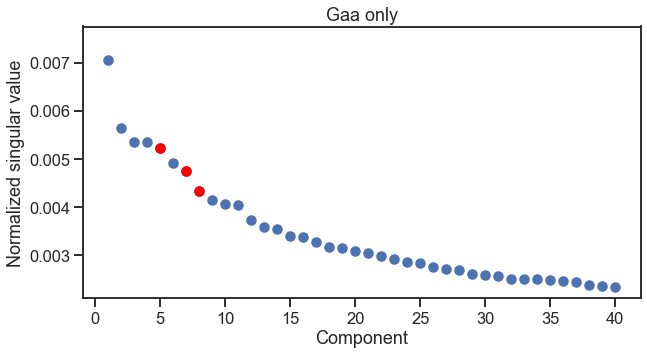

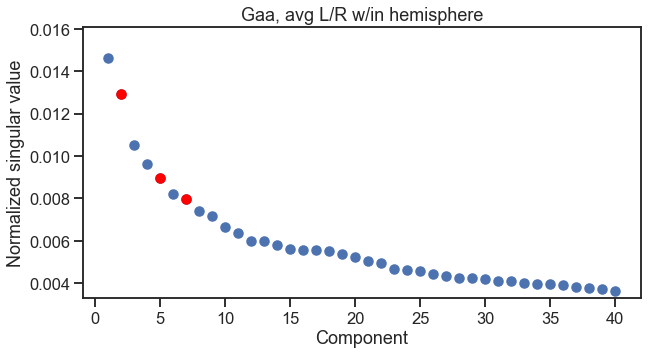

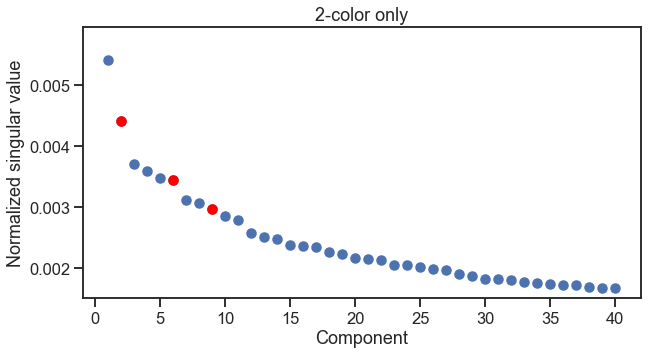

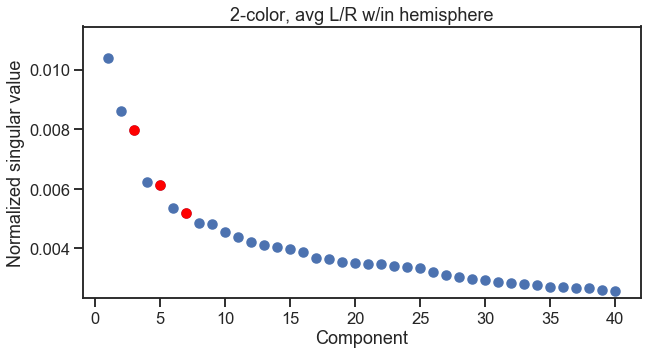

In [11]:
# 4 kinds of embedding:
# LSE on Flat
# LSE on L/R average
# OMNI on 2- or 4- color
# OMNI on 2- or 4- color, L/R average

# Parameters for the whole thing
ptr = True
augment_diag = False  # non-functional
n_components = 6
axo_only = True
n_verts = n_per_side * 2
n_colors = 4
if axo_only:
    n_colors = 2
method = "ase"

# LSE on Flat
regularizer = 1
flat_adj = get_paired_adj("Gad", nodelist)
embed_adj = pass_to_ranks(flat_adj)
screeplot(embed_adj, show_first=40, cumulative=False, n_elbows=3, title="Gaa only")
if method == "lse":
    embedder = LaplacianSpectralEmbed(n_components=n_components, form="R-DAD")
elif method == "ase":
    embedder = AdjacencySpectralEmbed(n_components=n_components)
flat_latent = embedder.fit_transform(embed_adj)
flat_latent = np.concatenate(flat_latent, axis=-1)
print("Computed latent positions for LSE on flat graph")
print(flat_latent.shape)
print()

# LSE on L/R average
avg_adj = flat_adj[:n_per_side, :n_per_side] + flat_adj[n_per_side:, n_per_side:]
embed_adj = pass_to_ranks(avg_adj)
screeplot(embed_adj, show_first=40, cumulative=False, n_elbows=3, title="Gaa, avg L/R w/in hemisphere")
if method == "lse":
    embedder = LaplacianSpectralEmbed(n_components=n_components, form="R-DAD")
elif method == "ase":
    embedder = AdjacencySpectralEmbed(n_components=n_components)
avg_latent = embedder.fit_transform(embed_adj)
avg_latent = np.concatenate(avg_latent, axis=-1)
print("Computed latent positions for LSE on L/R average")
print(avg_latent.shape)
print()

# OMNI on 2- or 4- color
graph_types = ["Gad", "Gaa", "Gdd", "Gda"]
if axo_only:
    graph_types = graph_types[:2]

color_adjs = []
for t in graph_types:
    adj = get_paired_adj(t, nodelist)
    if ptr:
        adj = pass_to_ranks(adj)
    if method == "lse":
        adj = to_laplace(adj, form="R-DAD", regularizer=regularizer)
    color_adjs.append(adj)

# omni = OmnibusEmbed(n_components=n_components)
# TODO: should use /2 or /4 components?
omni_mat = _get_omni_matrix(color_adjs)
screeplot(omni_mat, show_first=40, cumulative=False, n_elbows=3, title="2-color only")
# laplacian_omni_mat = to_laplace(omni_mat, form="R-DAD", regularizer=regularizer)
omni = OmnibusEmbed(n_components=n_components)
color_latent = omni.fit_transform(color_adjs)
color_latent = np.concatenate(color_latent, axis=-1)
color_latent = np.concatenate(color_latent, axis=-1)

# color_latent = np.concatenate(color_latent, axis=-1)  # concatenate color graphs
print("Computed latent positions for OMNI on 2- or 4- color graph")
print(color_latent.shape)
print()

# OMNI on 2- or 4- color with averaging
avg_color_adjs = []
for t in graph_types:
    adj = get_paired_adj(t, nodelist)
    left_left_adj = adj[:n_per_side, :n_per_side]
    right_right_adj = adj[n_per_side:, n_per_side:]
    avg_adj = (left_left_adj + right_right_adj) / 2
    if ptr:
        avg_adj = pass_to_ranks(avg_adj)  # TODO: When to do PTR here?
    if method == "lse":
        avg_adj = to_laplace(avg_adj, form="R-DAD", regularizer=regularizer)
    avg_color_adjs.append(avg_adj)

omni_mat = _get_omni_matrix(avg_color_adjs)
screeplot(omni_mat, show_first=40, cumulative=False, n_elbows=3, title="2-color, avg L/R w/in hemisphere")
omni = OmnibusEmbed(n_components=n_components)
avg_color_latent = omni.fit_transform(avg_color_adjs)
# avg_color_latent = [a.reshape(n_per_side, -1) for a in avg_color_latent]
avg_color_latent = np.concatenate(avg_color_latent, axis=-1)
avg_color_latent = np.concatenate(avg_color_latent, axis=-1)

# avg_color_latent = np.concatenate(
#     (avg_color_latent[:n_per_side], avg_color_latent[n_per_side:])
# )
# avg_color_latent = np.concatenate(avg_color_latent, axis=-1) #this would be with omni
print("Computed latent positions for OMNI on 2- or 4- color graph L/R averages")
print(avg_color_latent.shape)
print()


# Clustering

We want to cluster their graph, but we also want to know what does the pairing/multicolor graph buy us? Here, I will cluster the 4 types of embedding described above for various number of clusters. One possible way to evaluate which clusterings make more sense is by looking at how predefined cell classes get clustered. Though I would not consider these "ground truth" clusters, I do think the following cell classes are anatomically well-defined and we can trust the labels: 
- DAN
- KC 
- MBON 
- MBIN 
- OAN 
- _PN

The others we shouldn't really trust for now... 

## Details: 
- Using spherical kmeans (project the embeddings to the unit sphere, and cluster on it)
- Taking 500 random inits, they are evaluated on within-cluster sum of squares currently

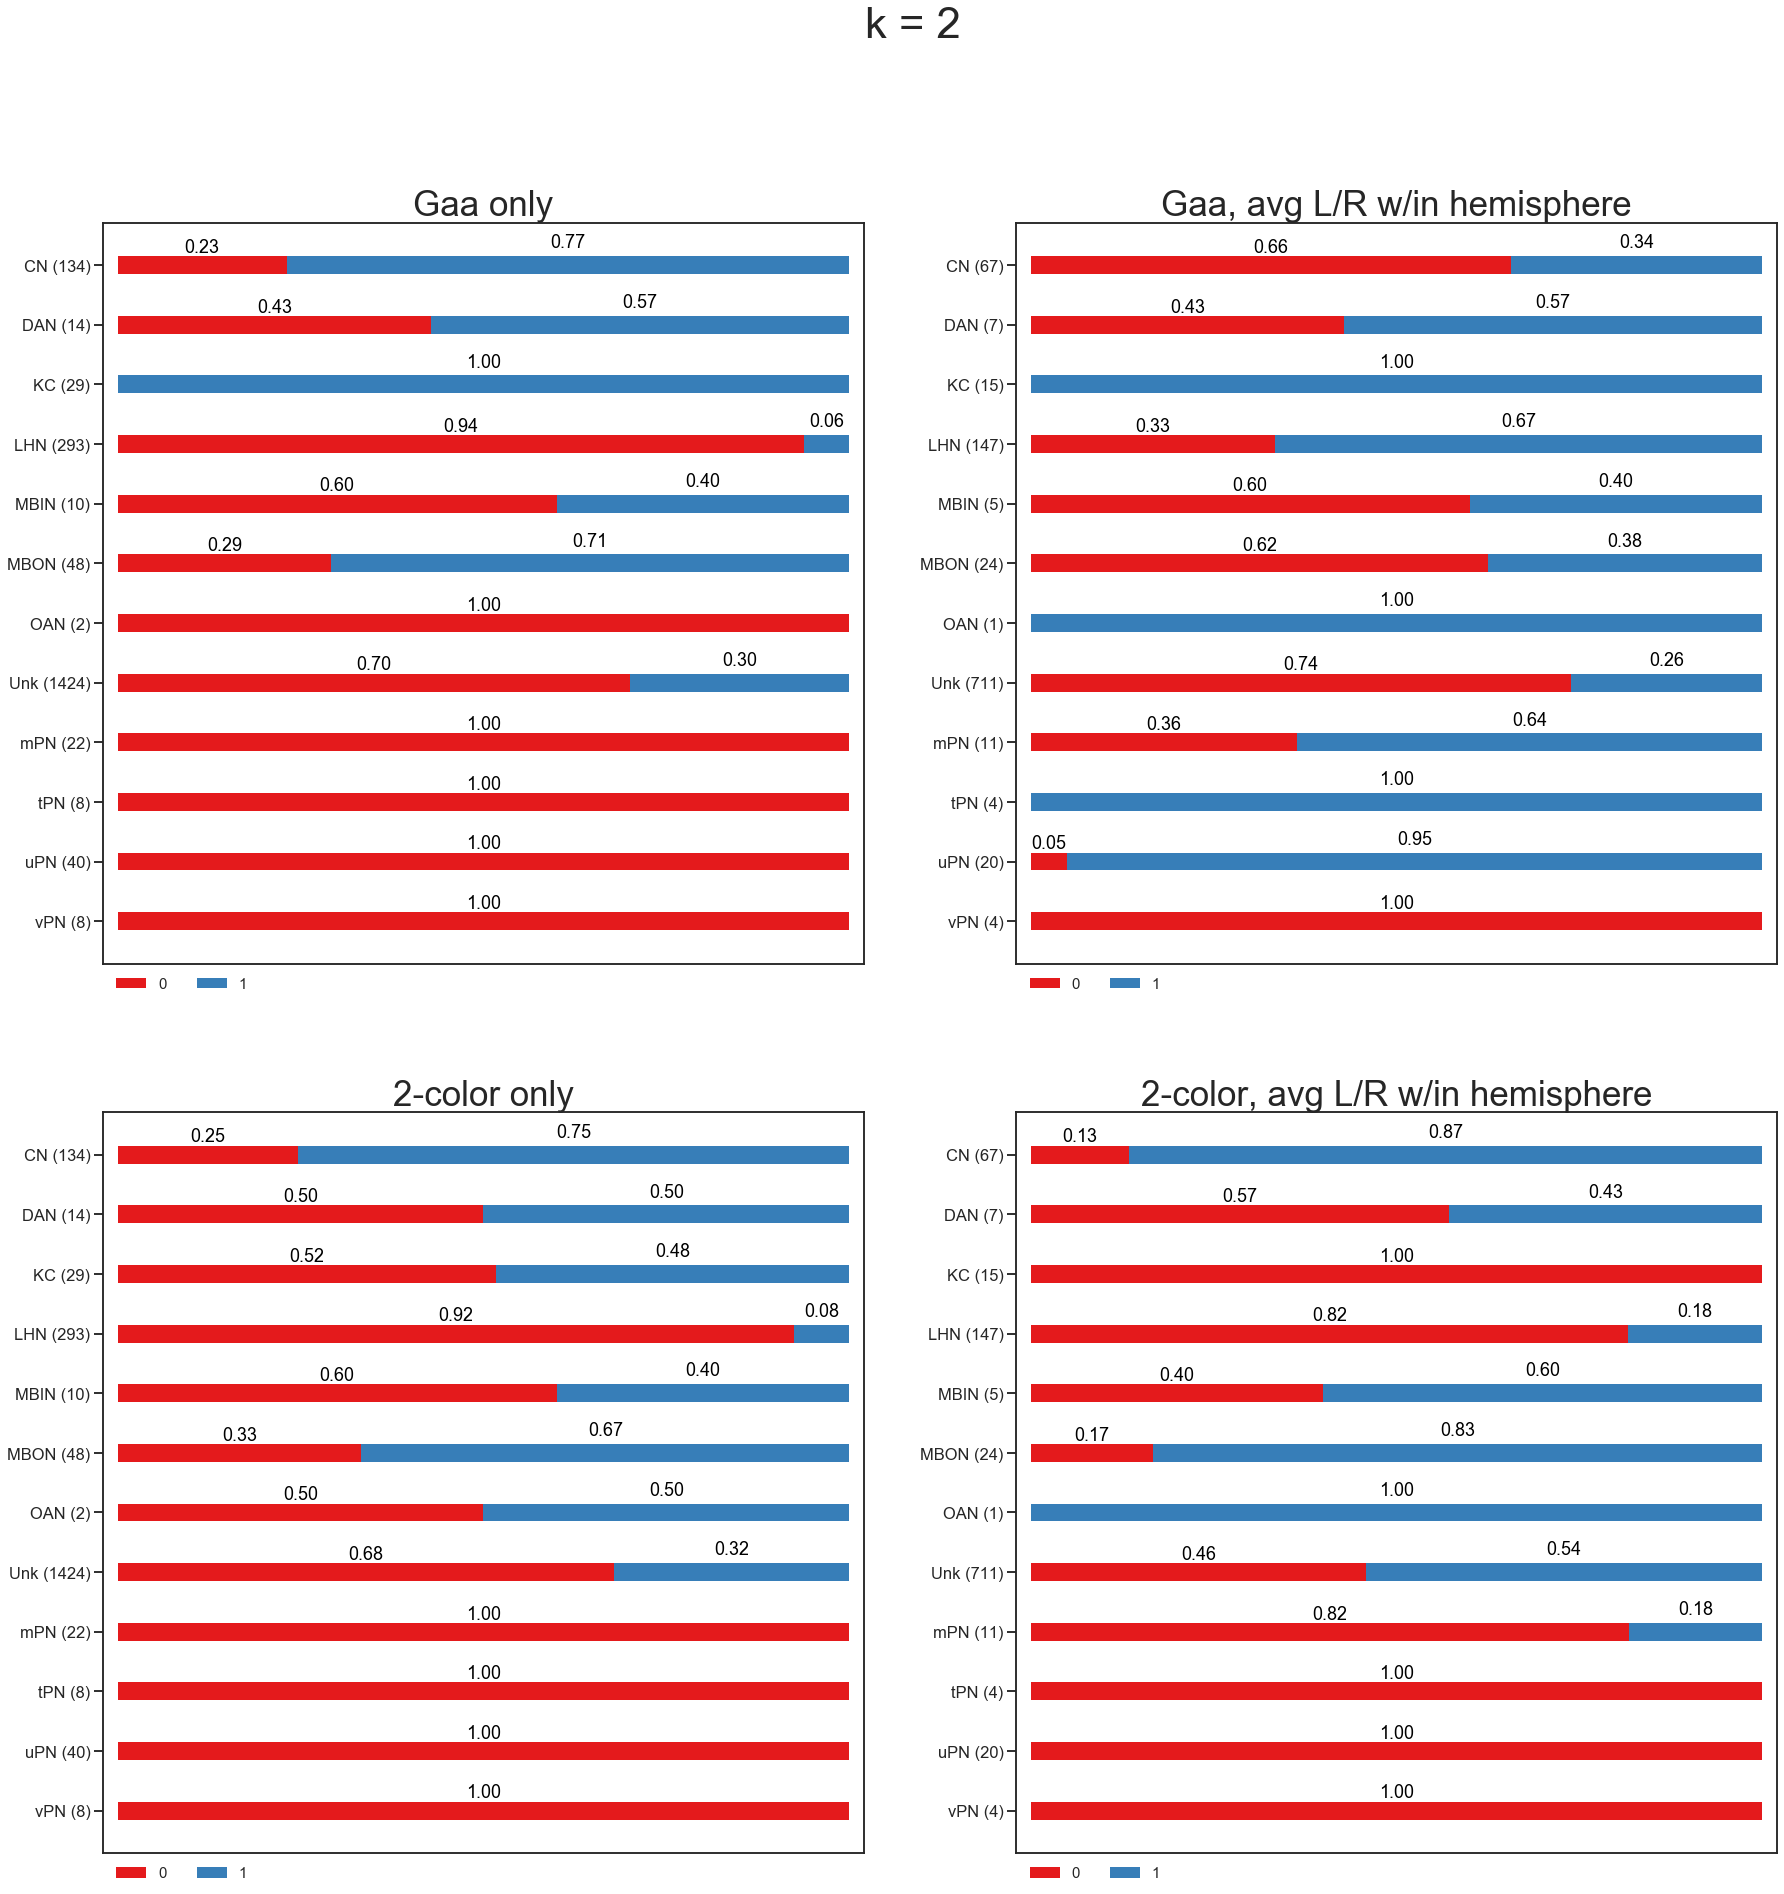

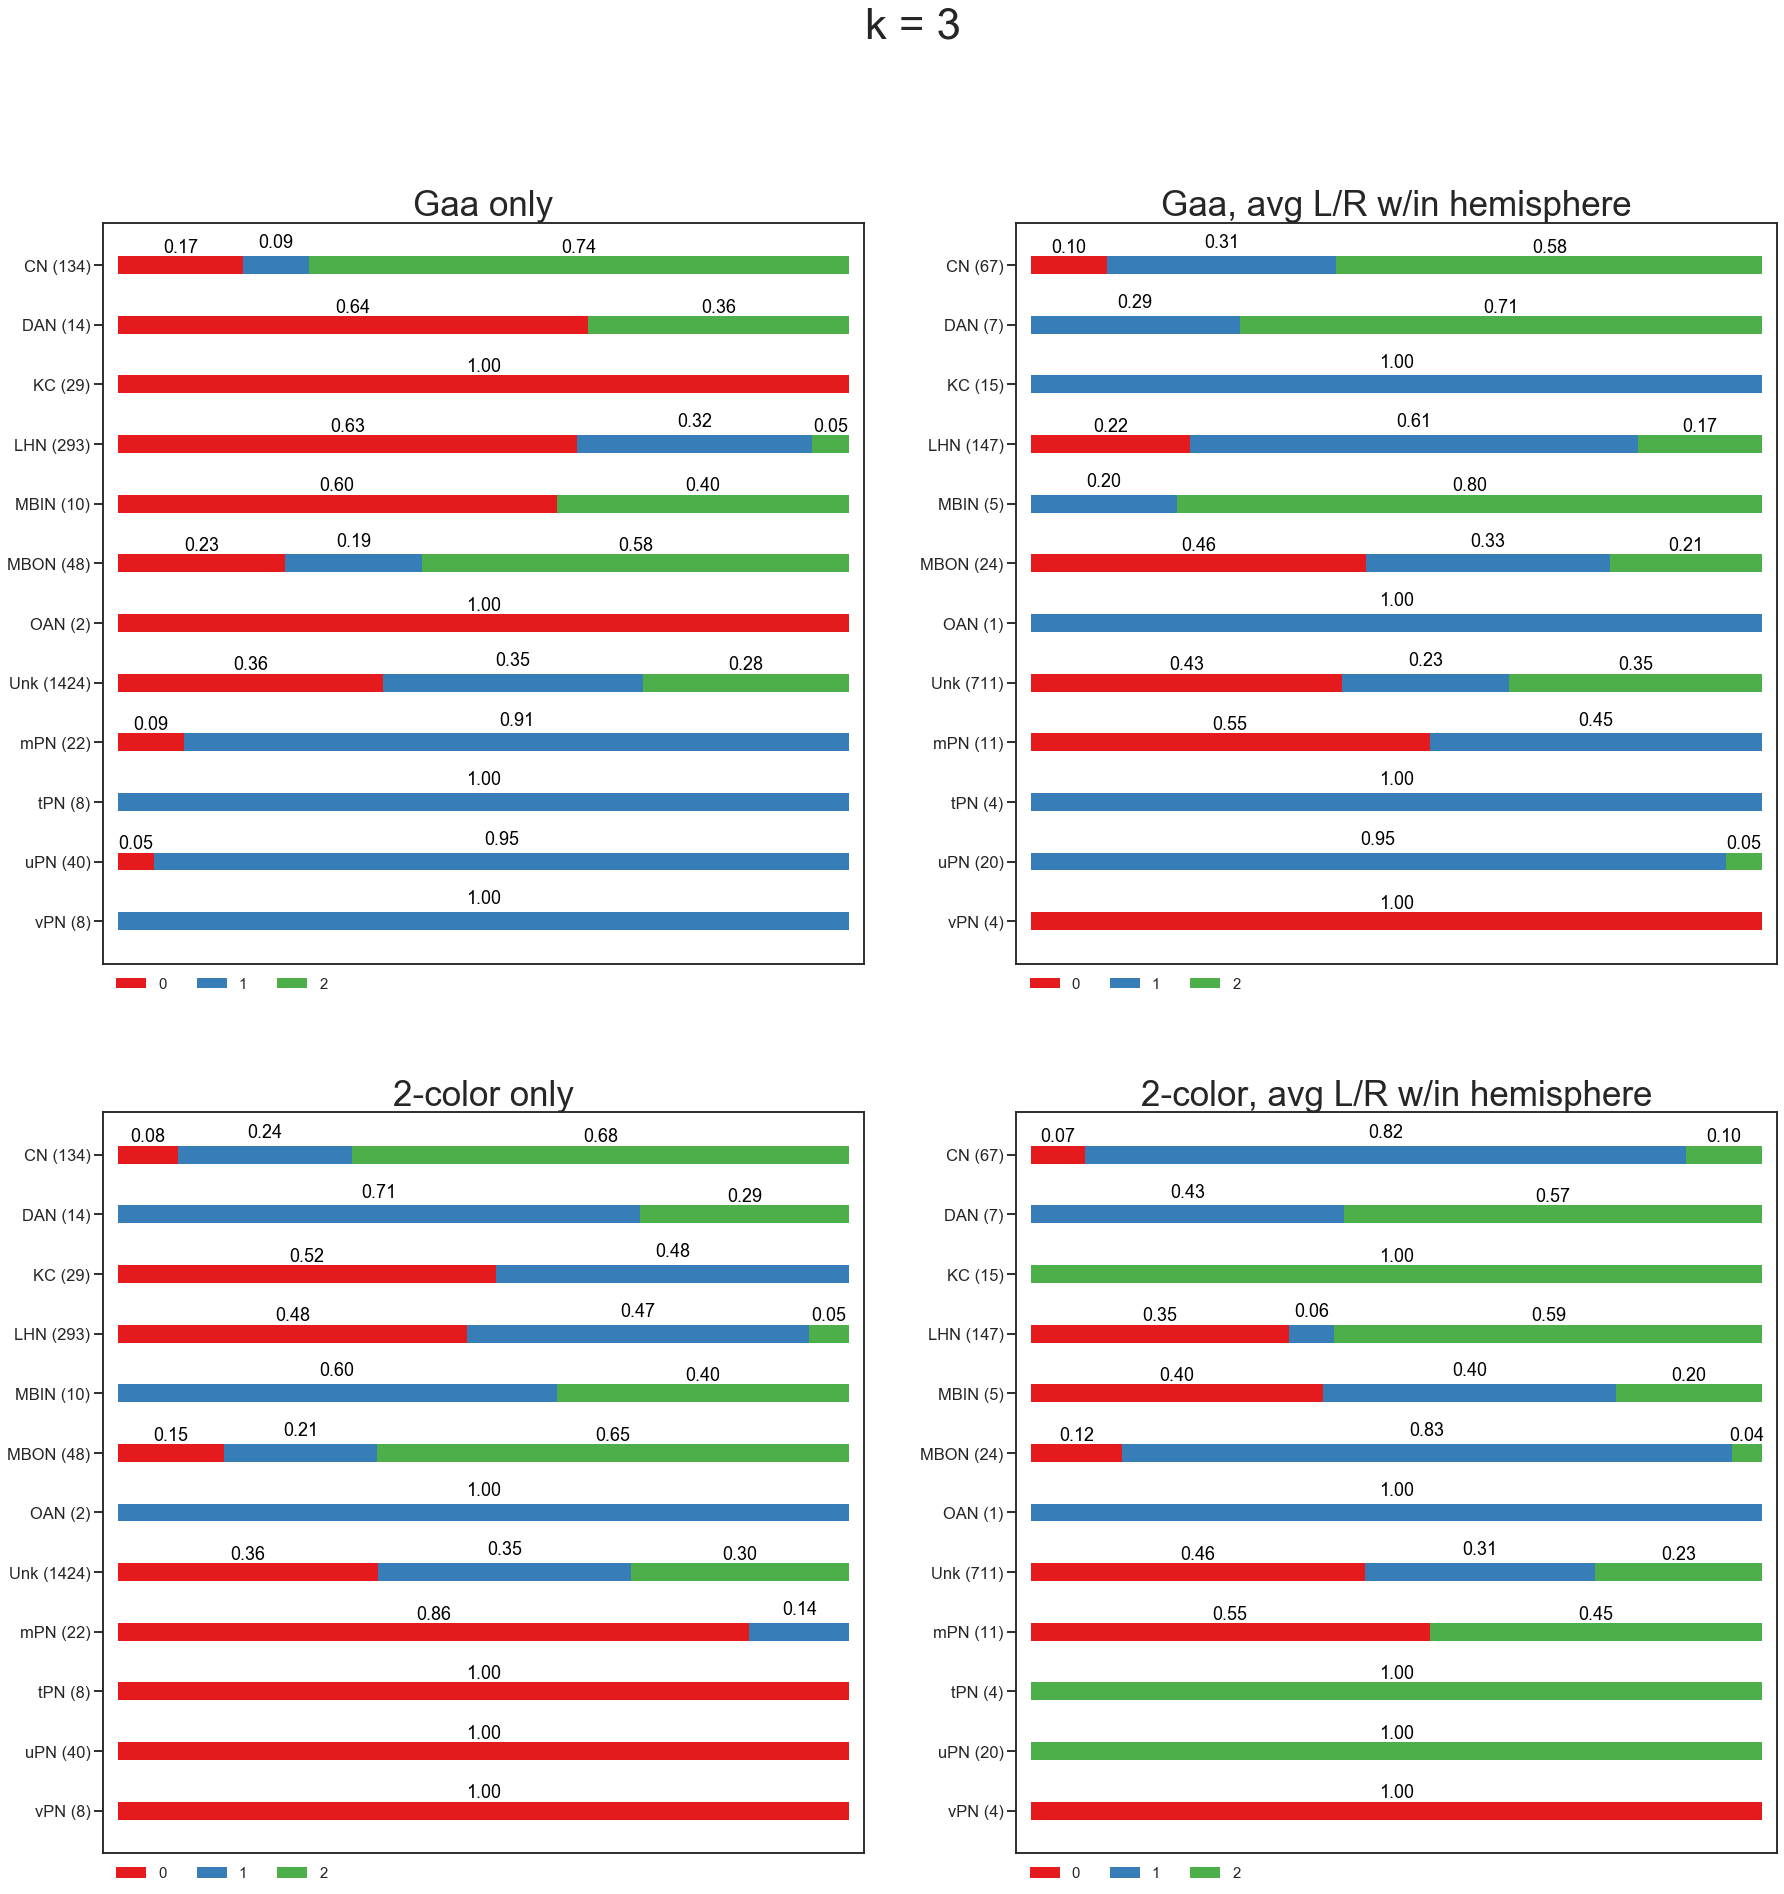

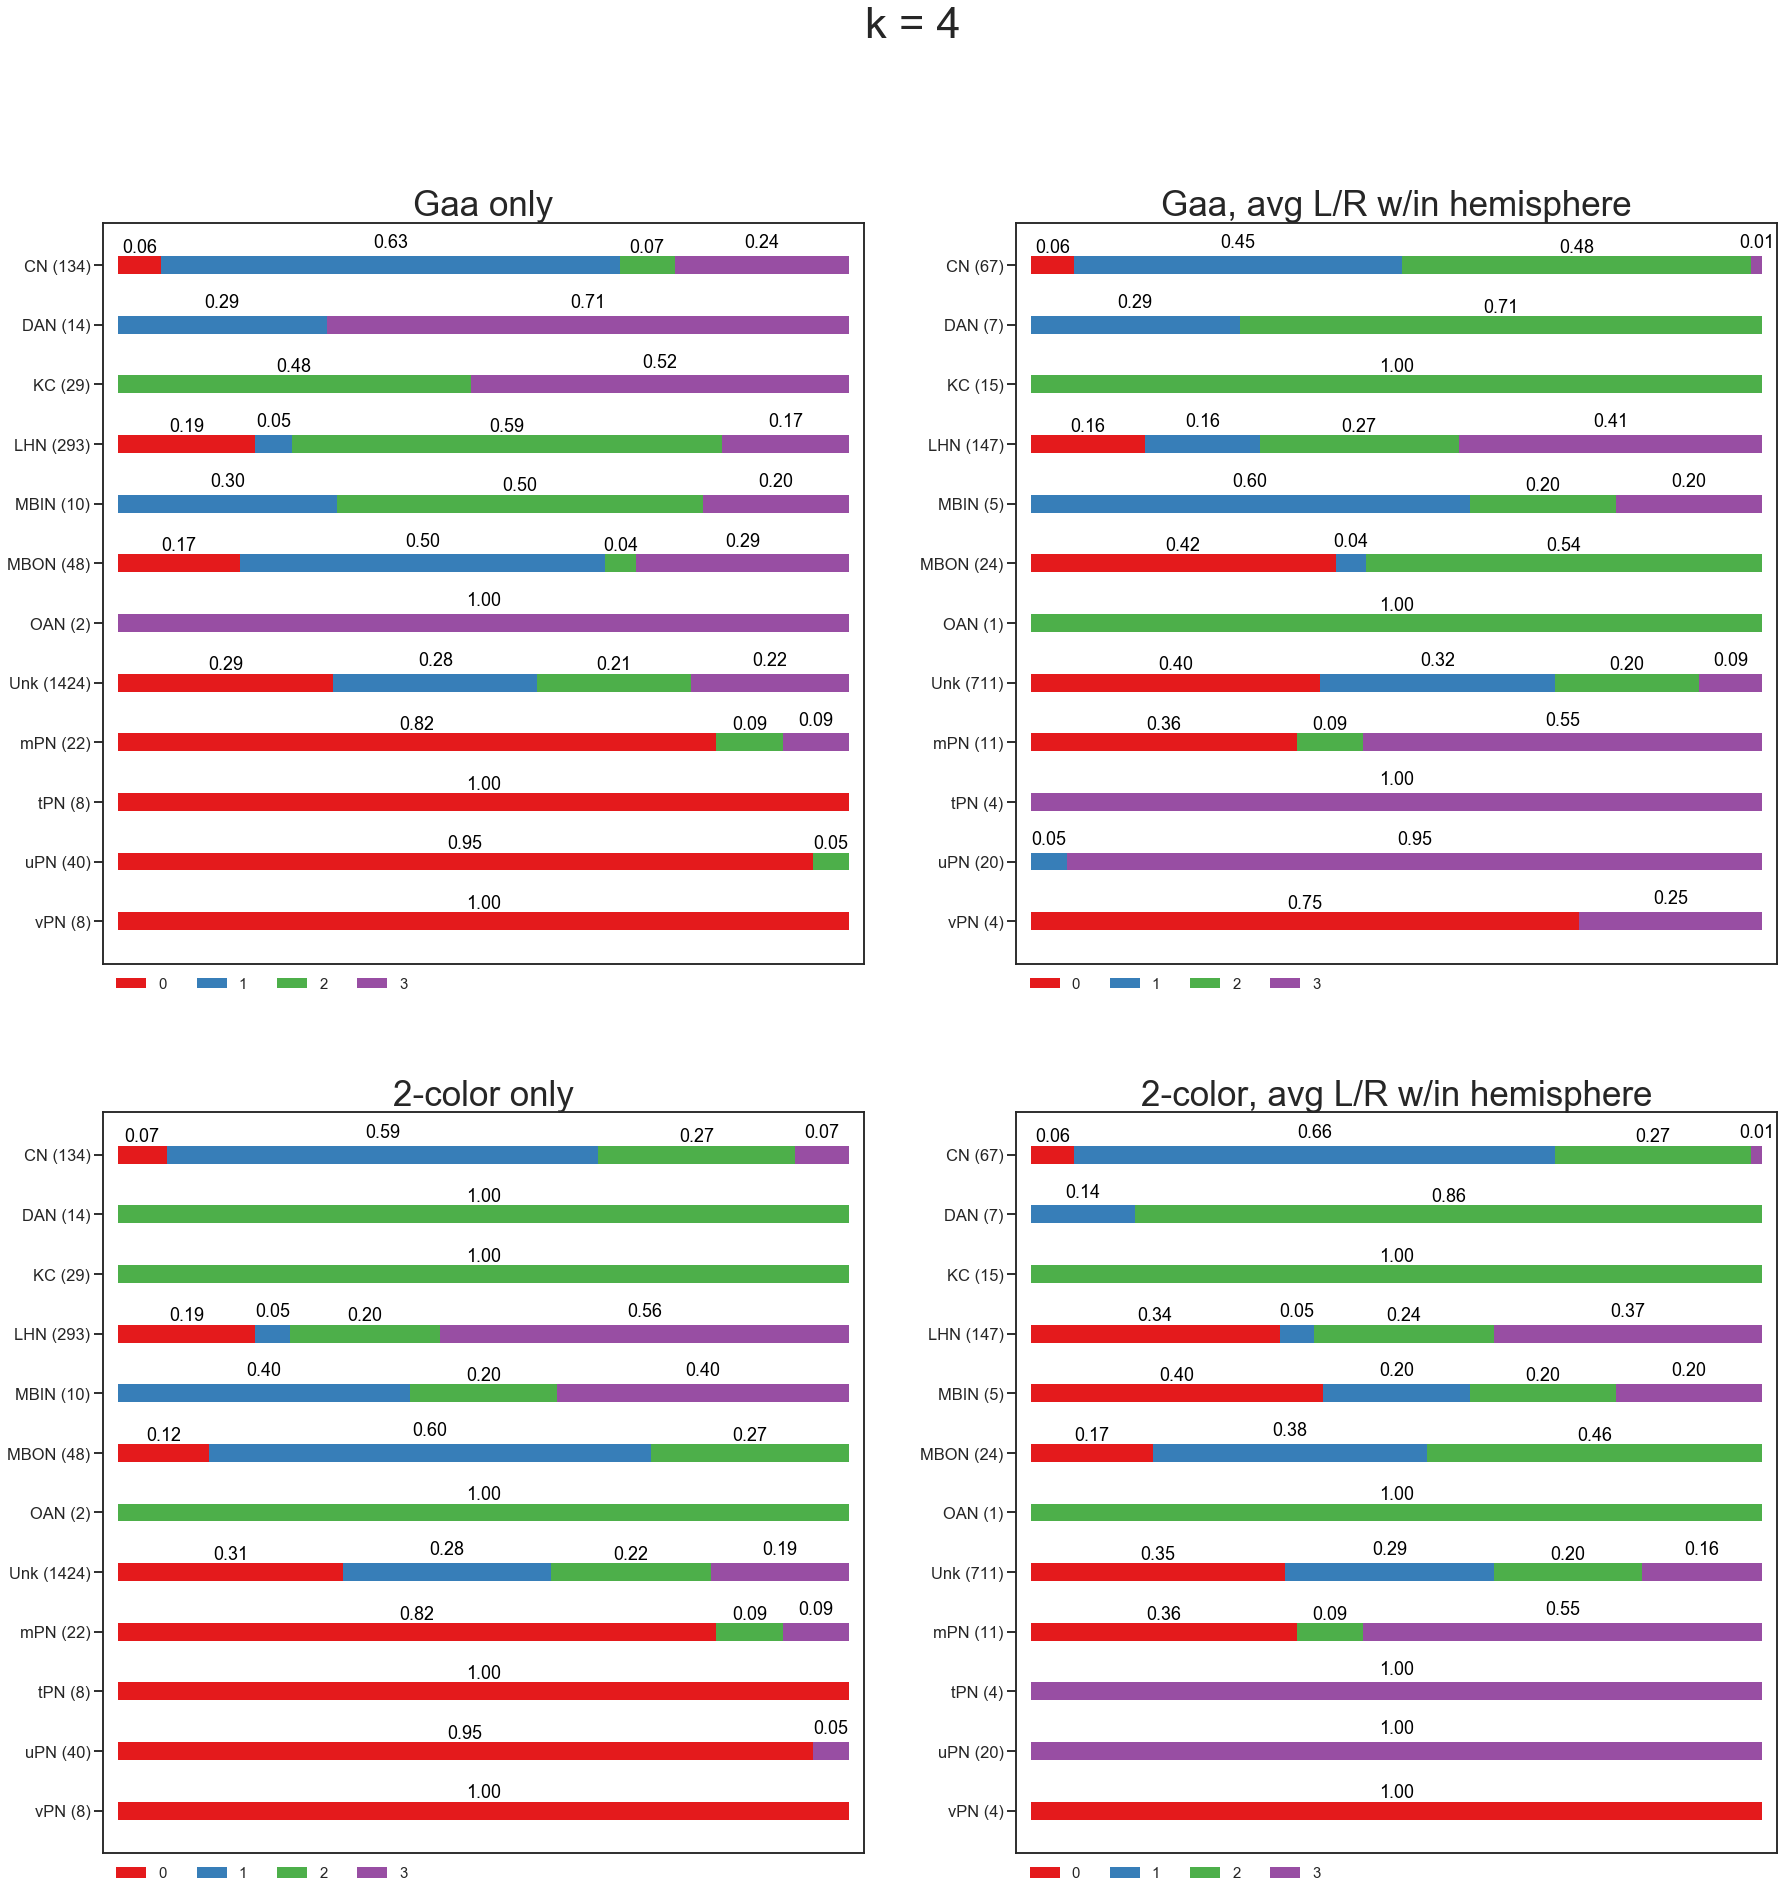

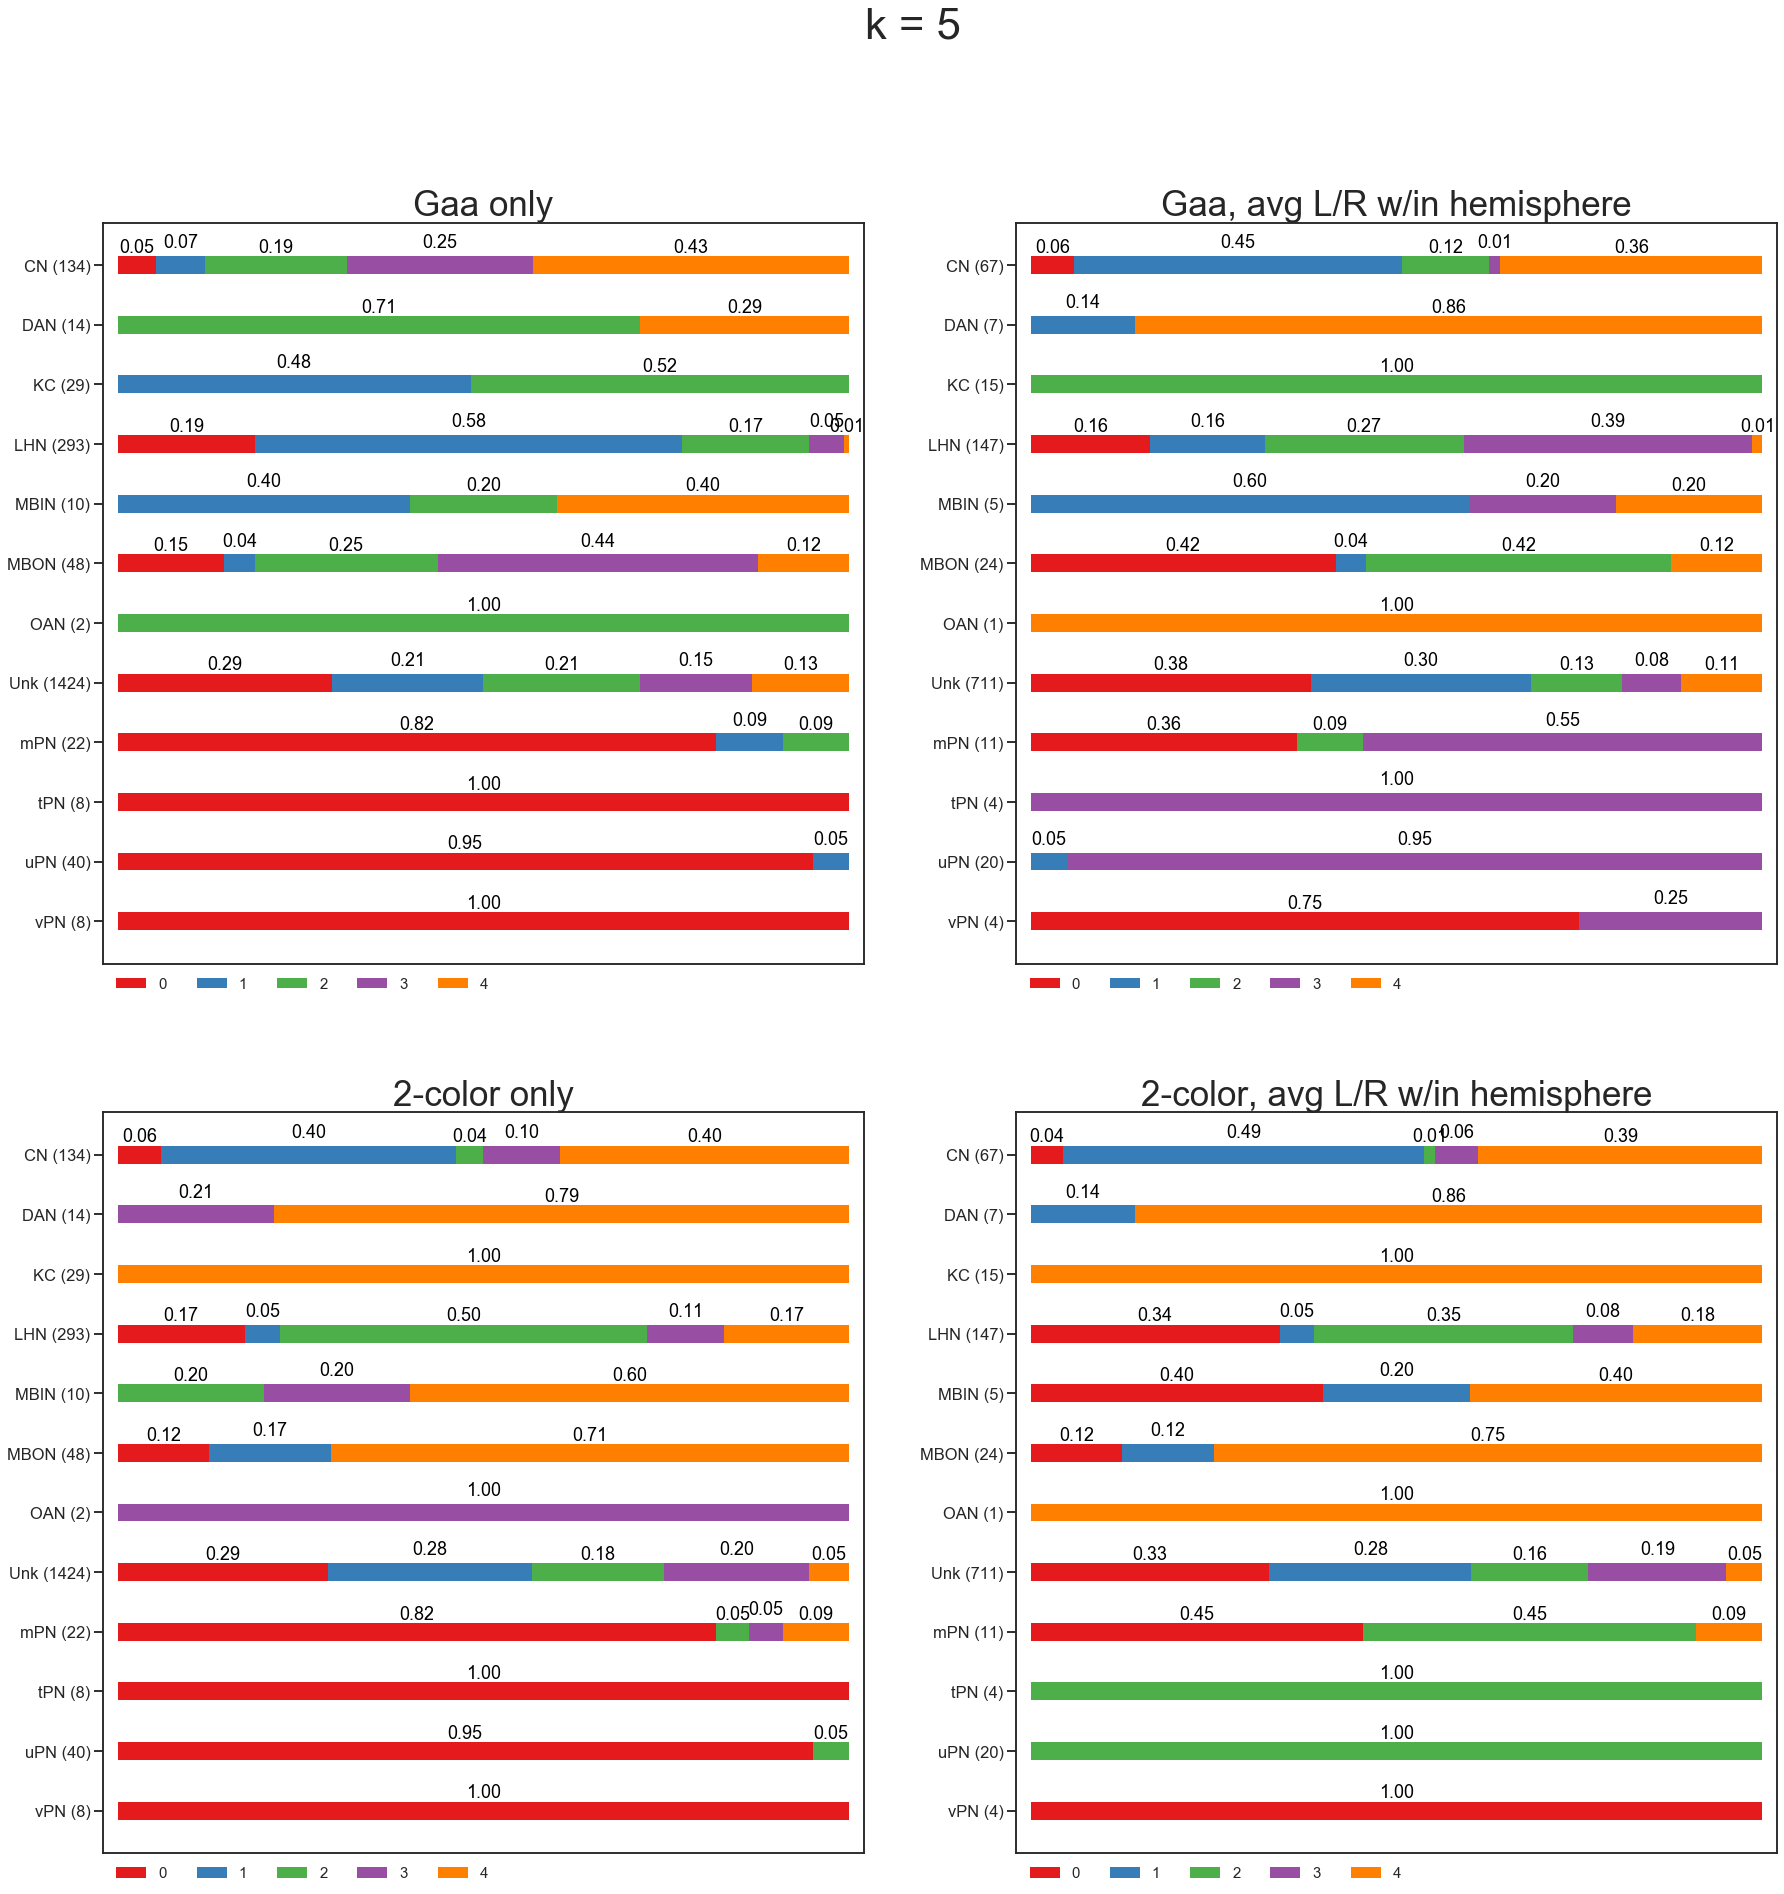

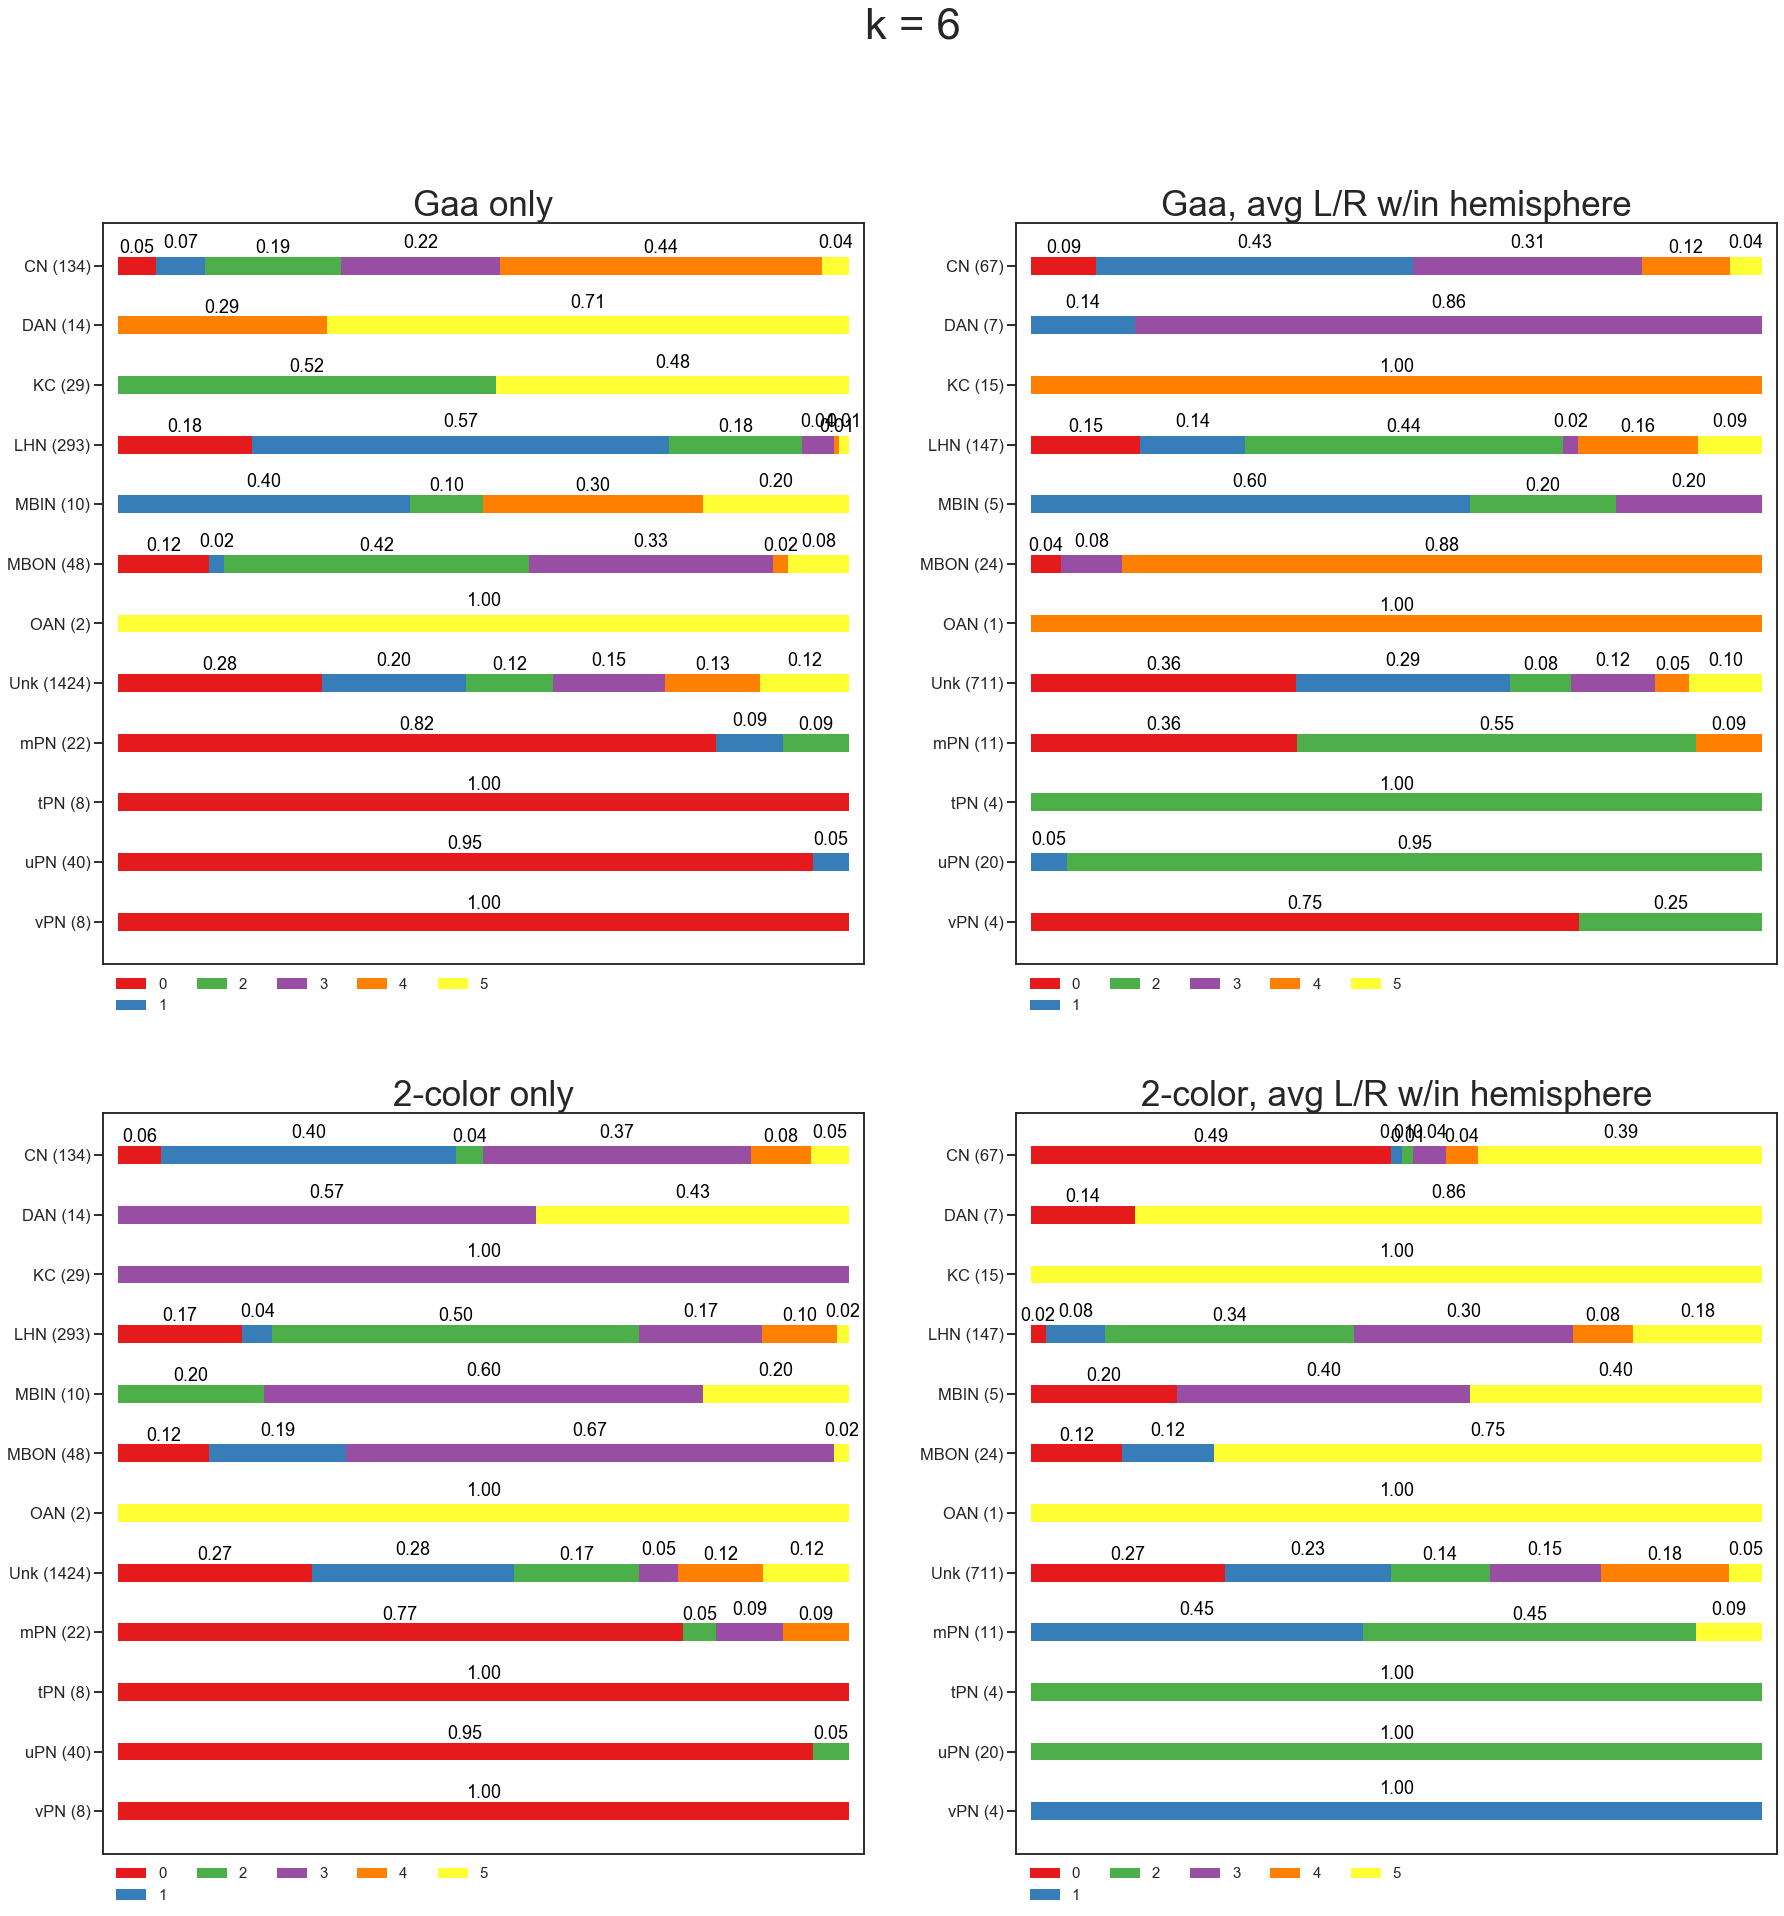

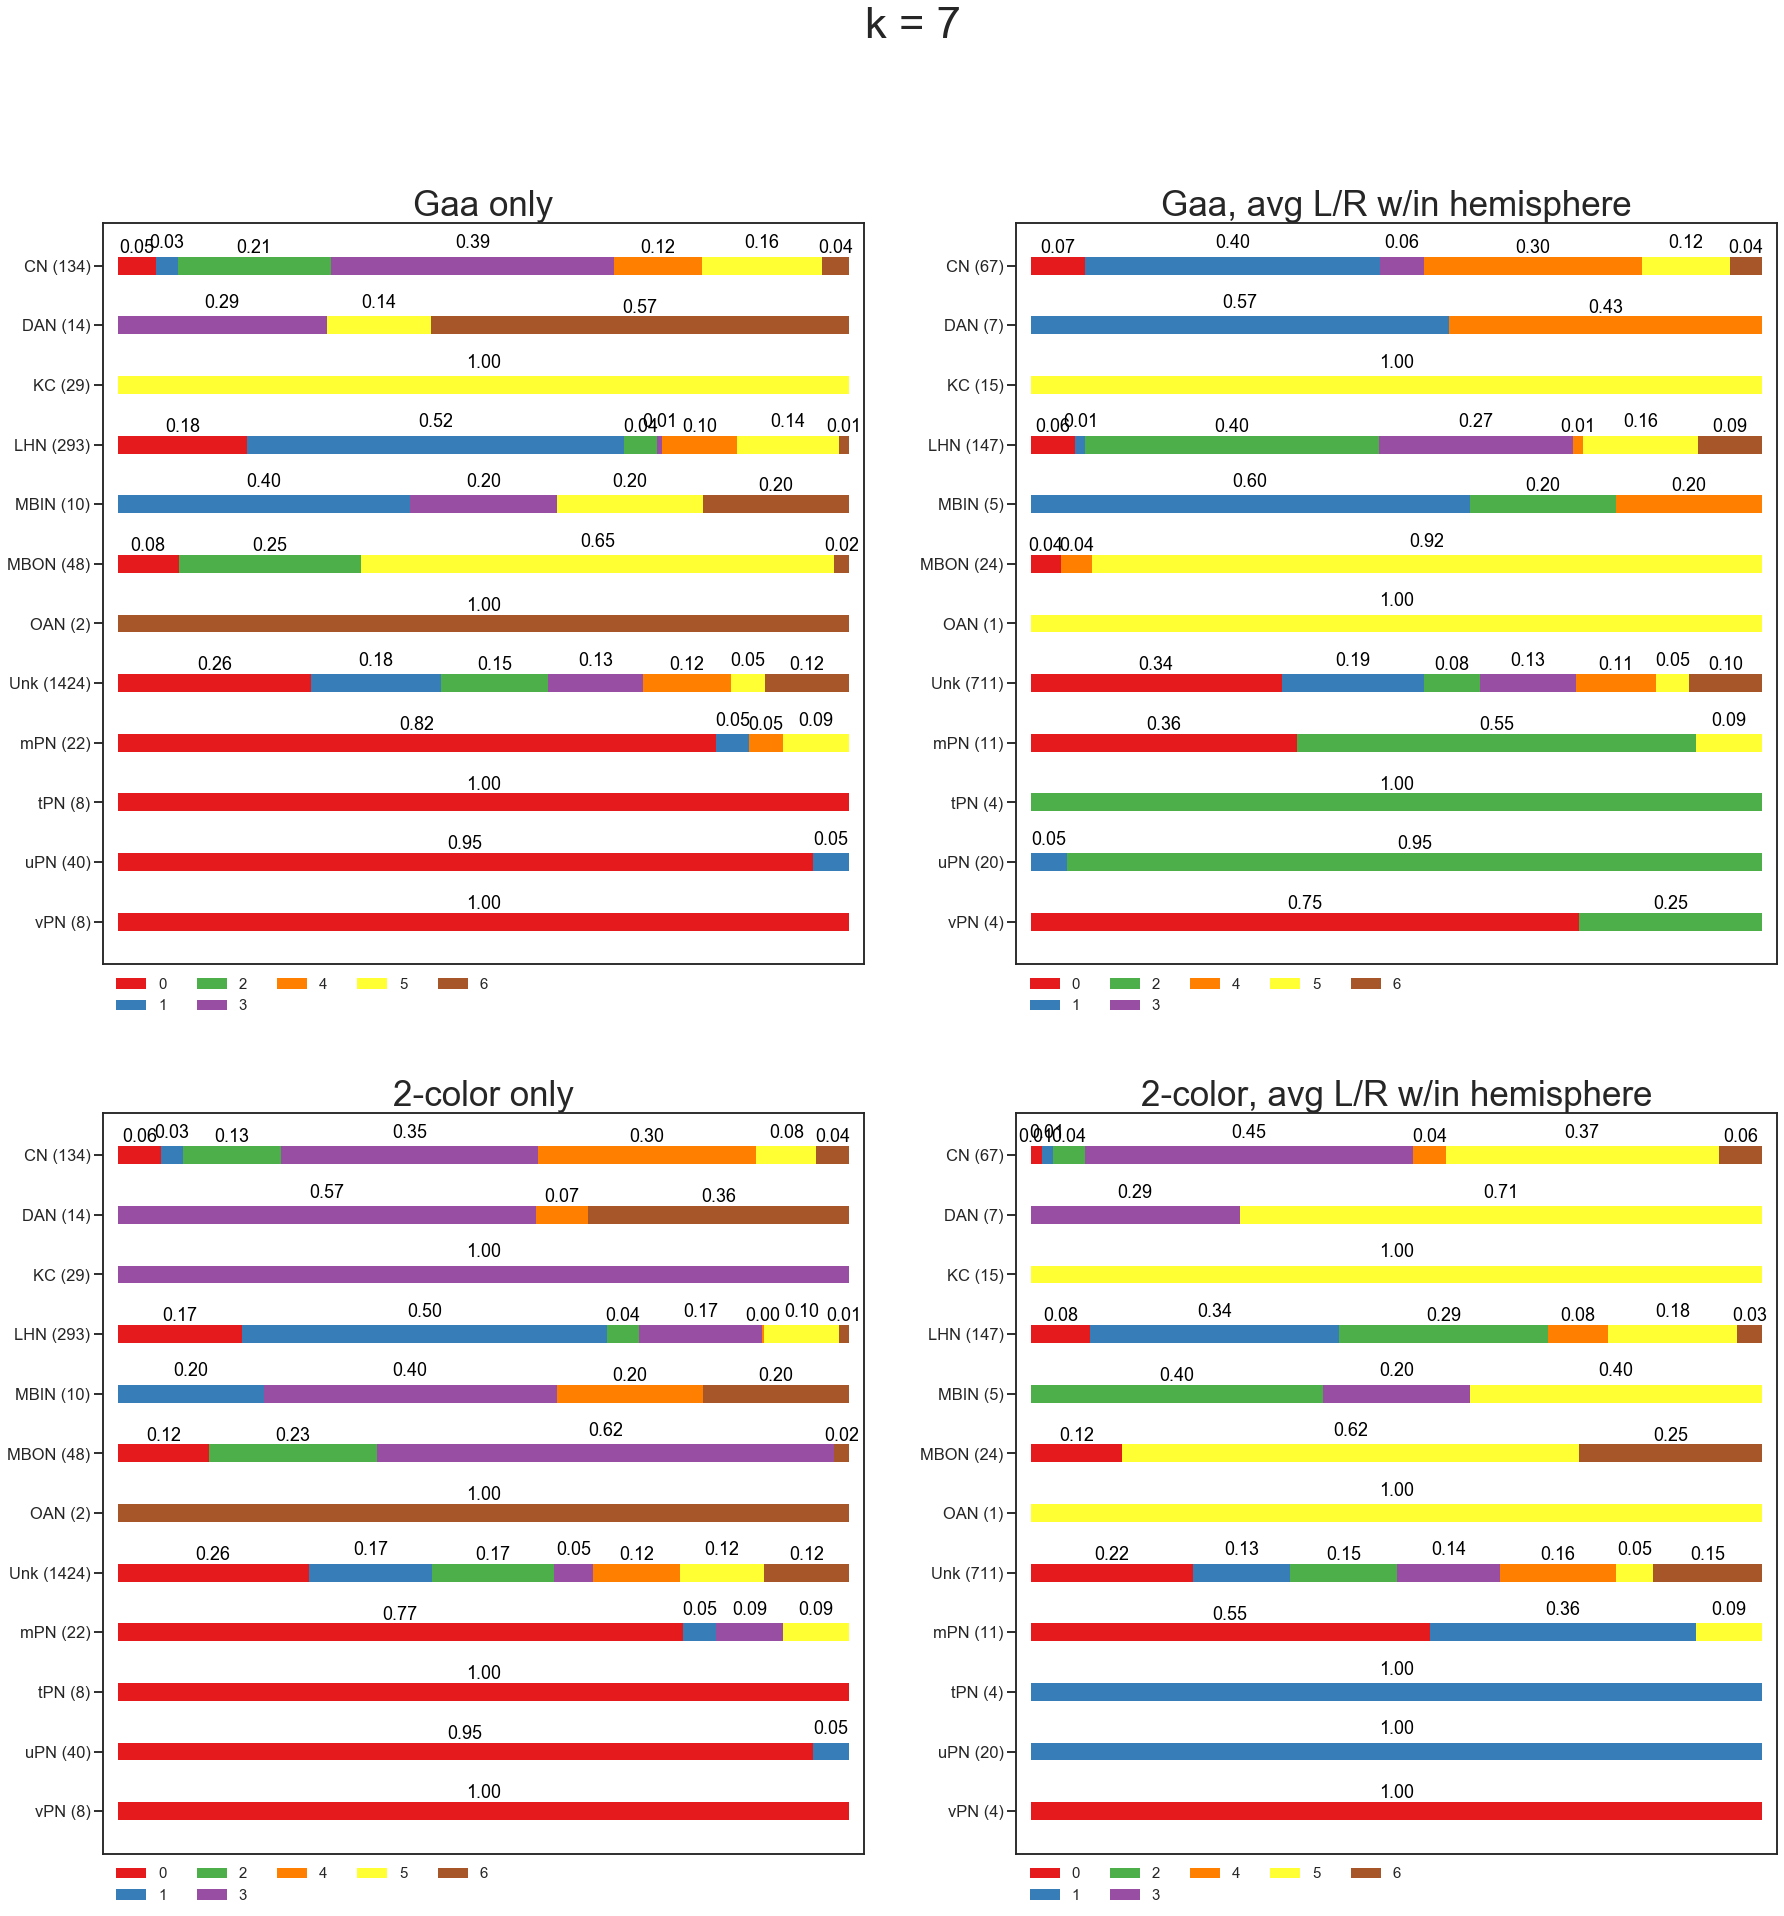

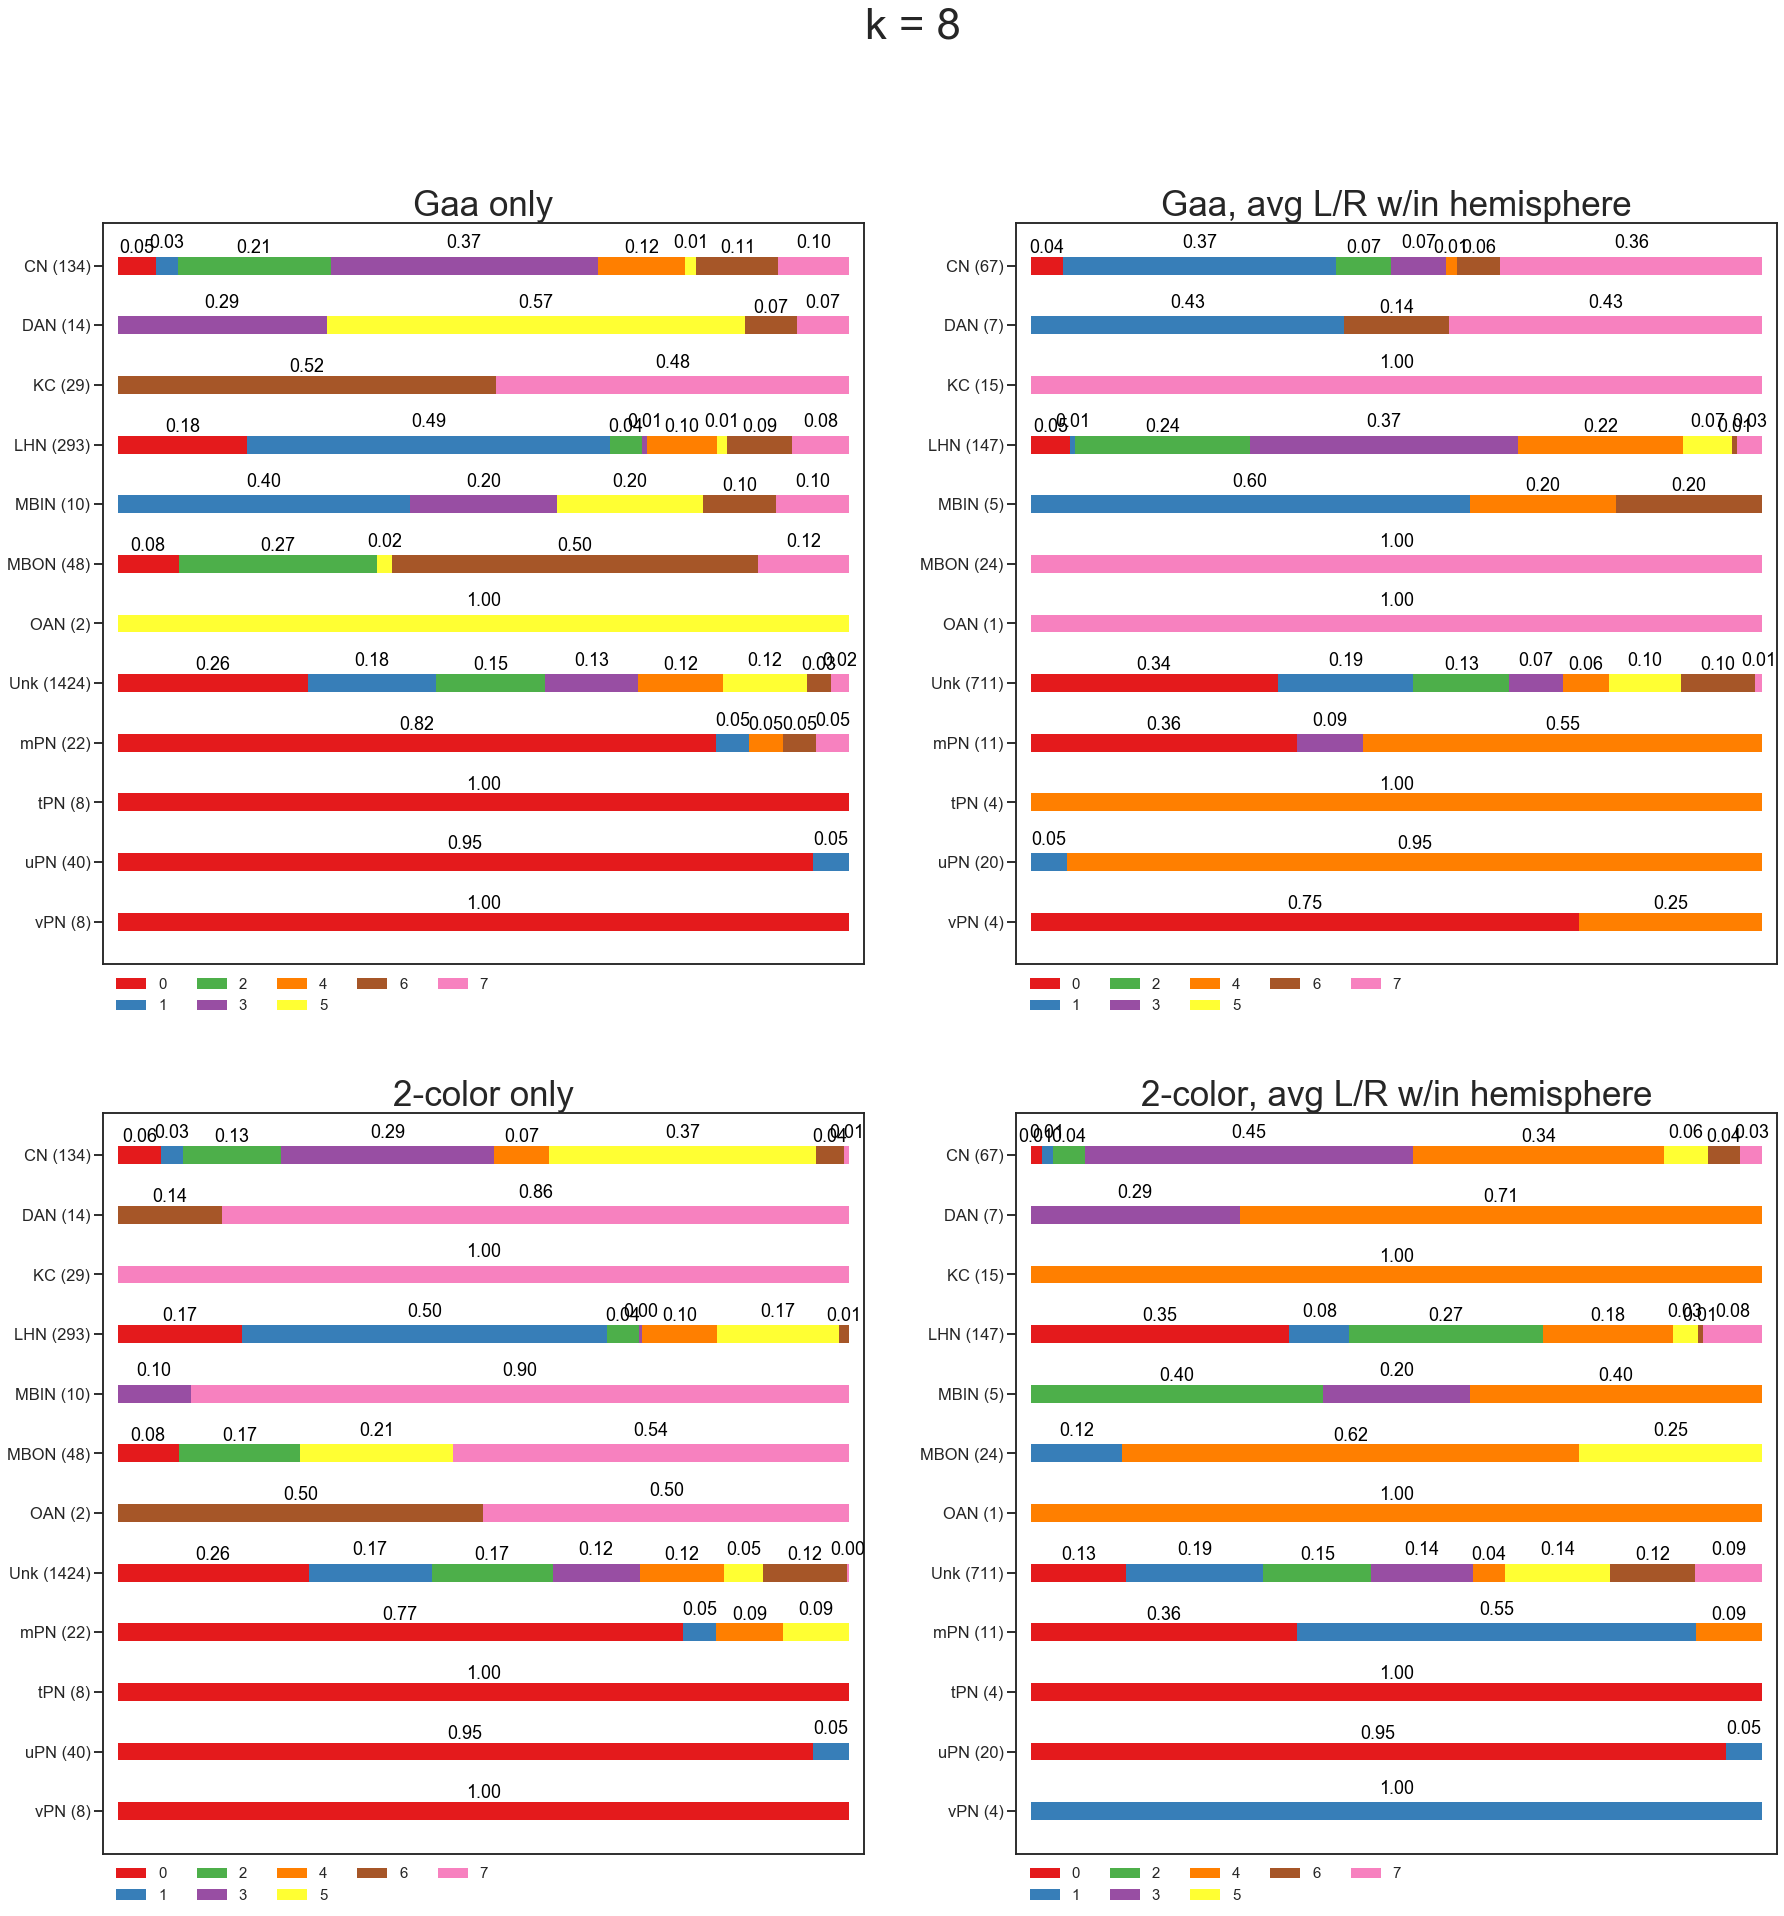

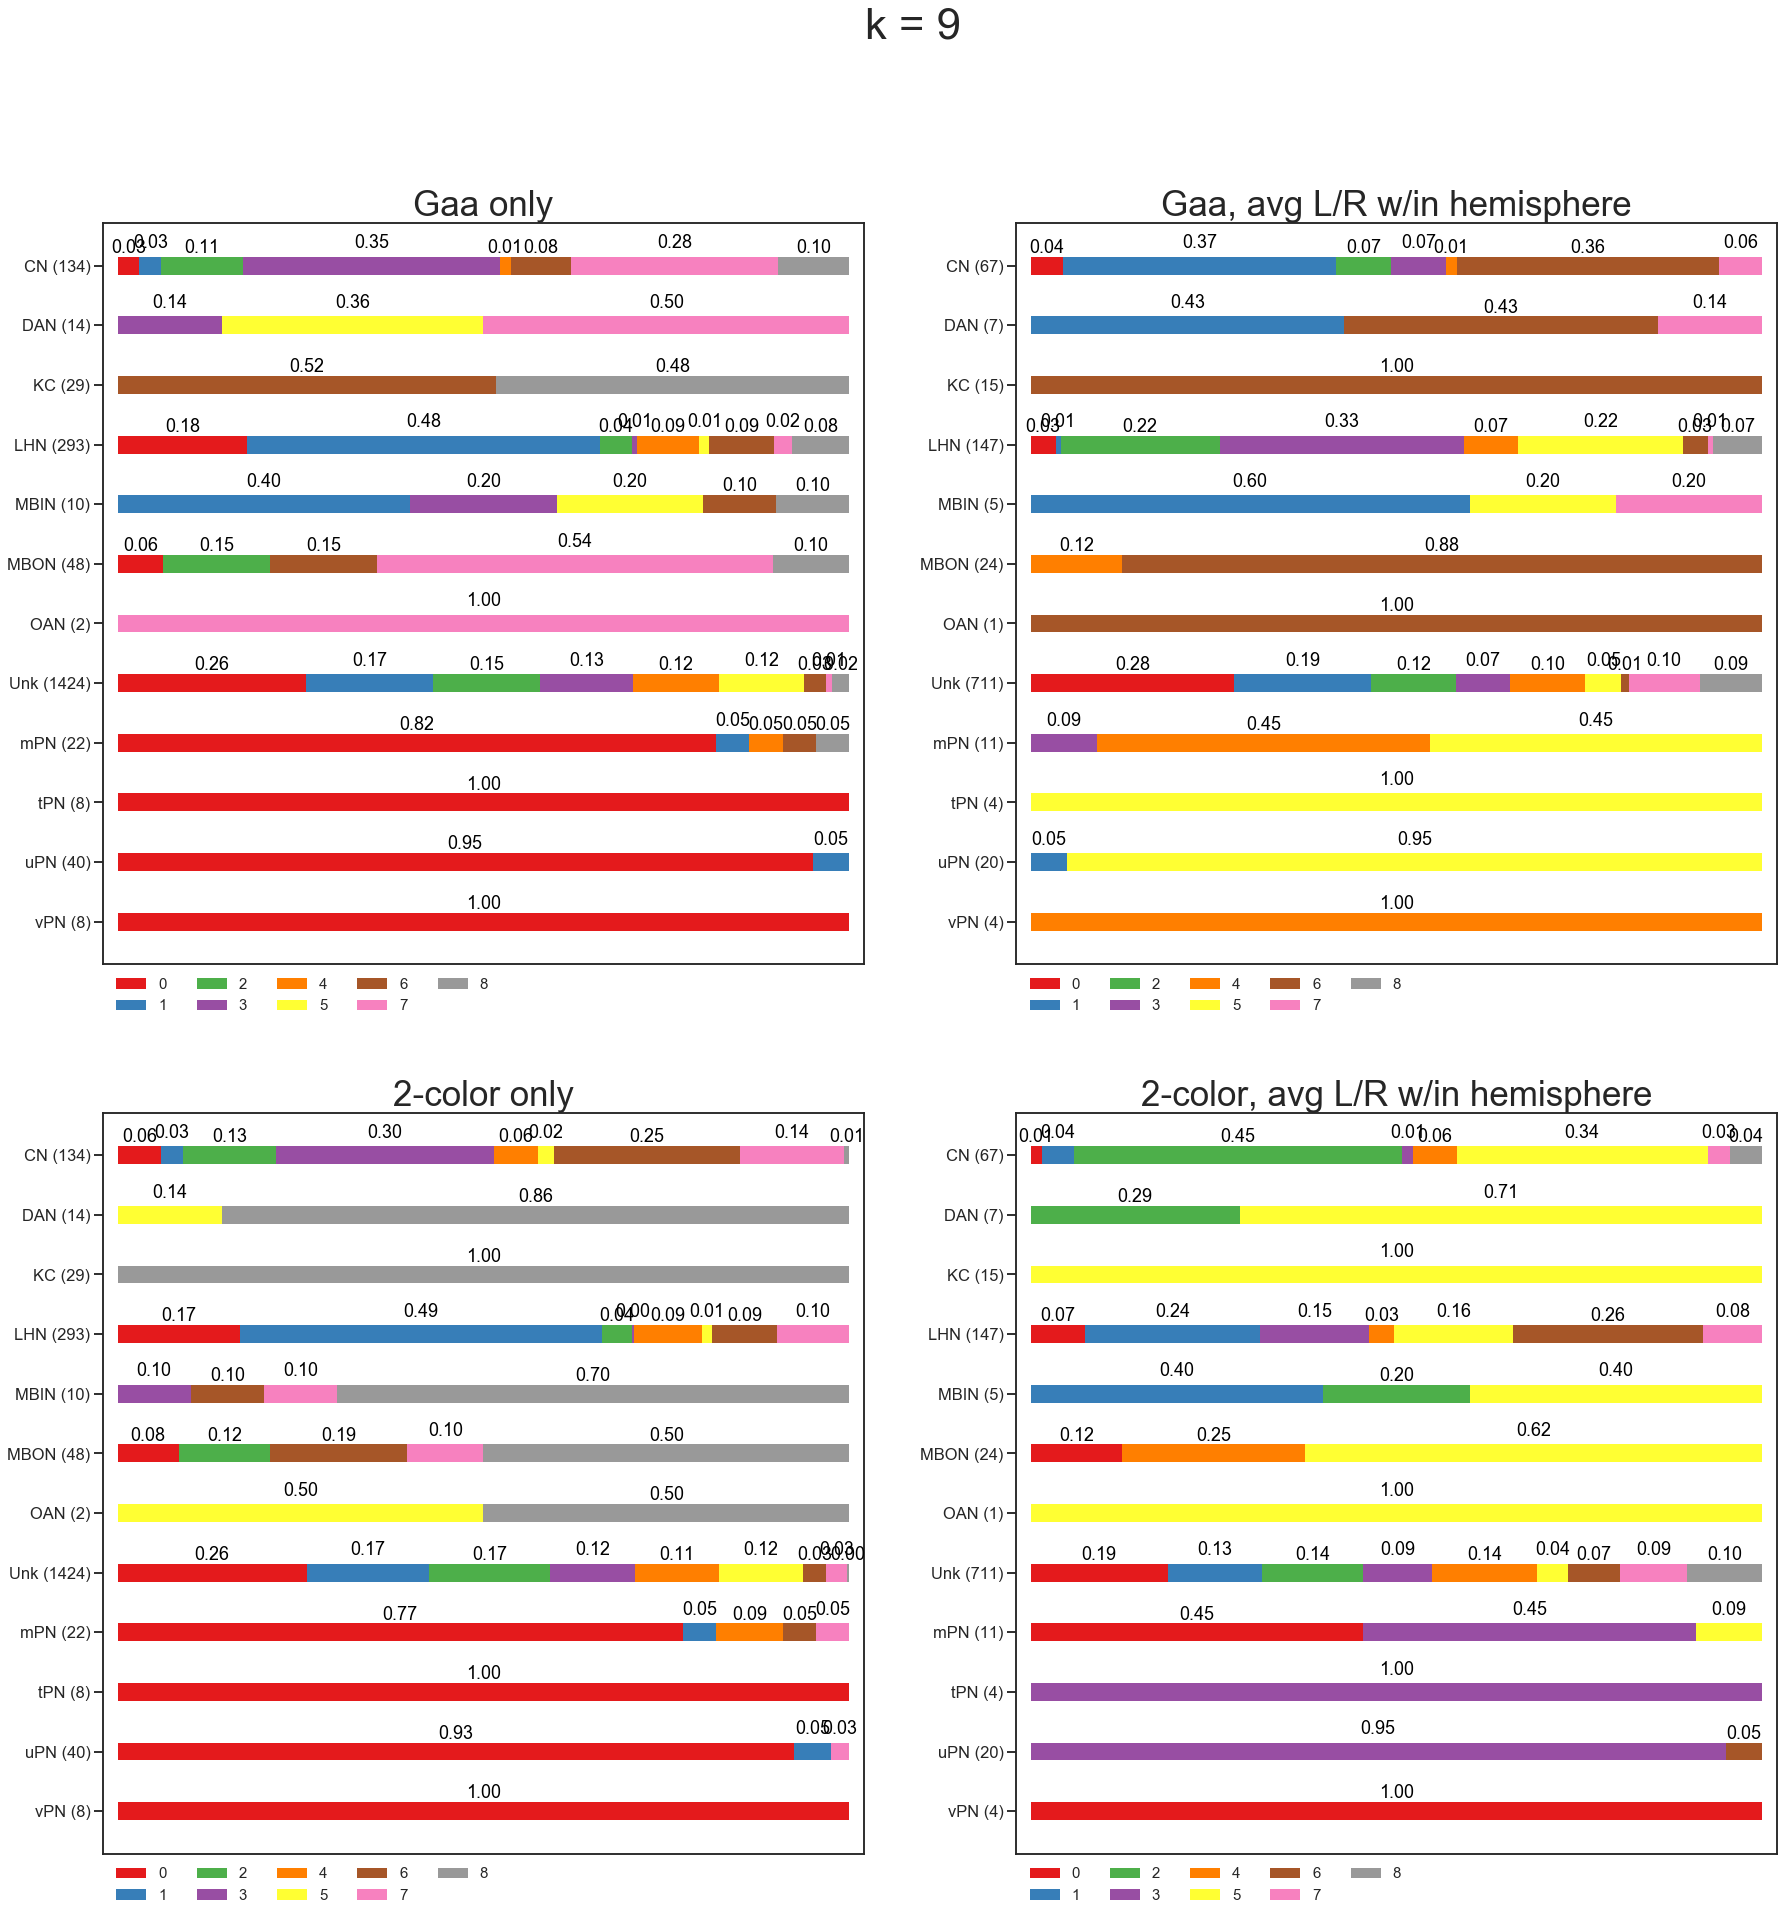

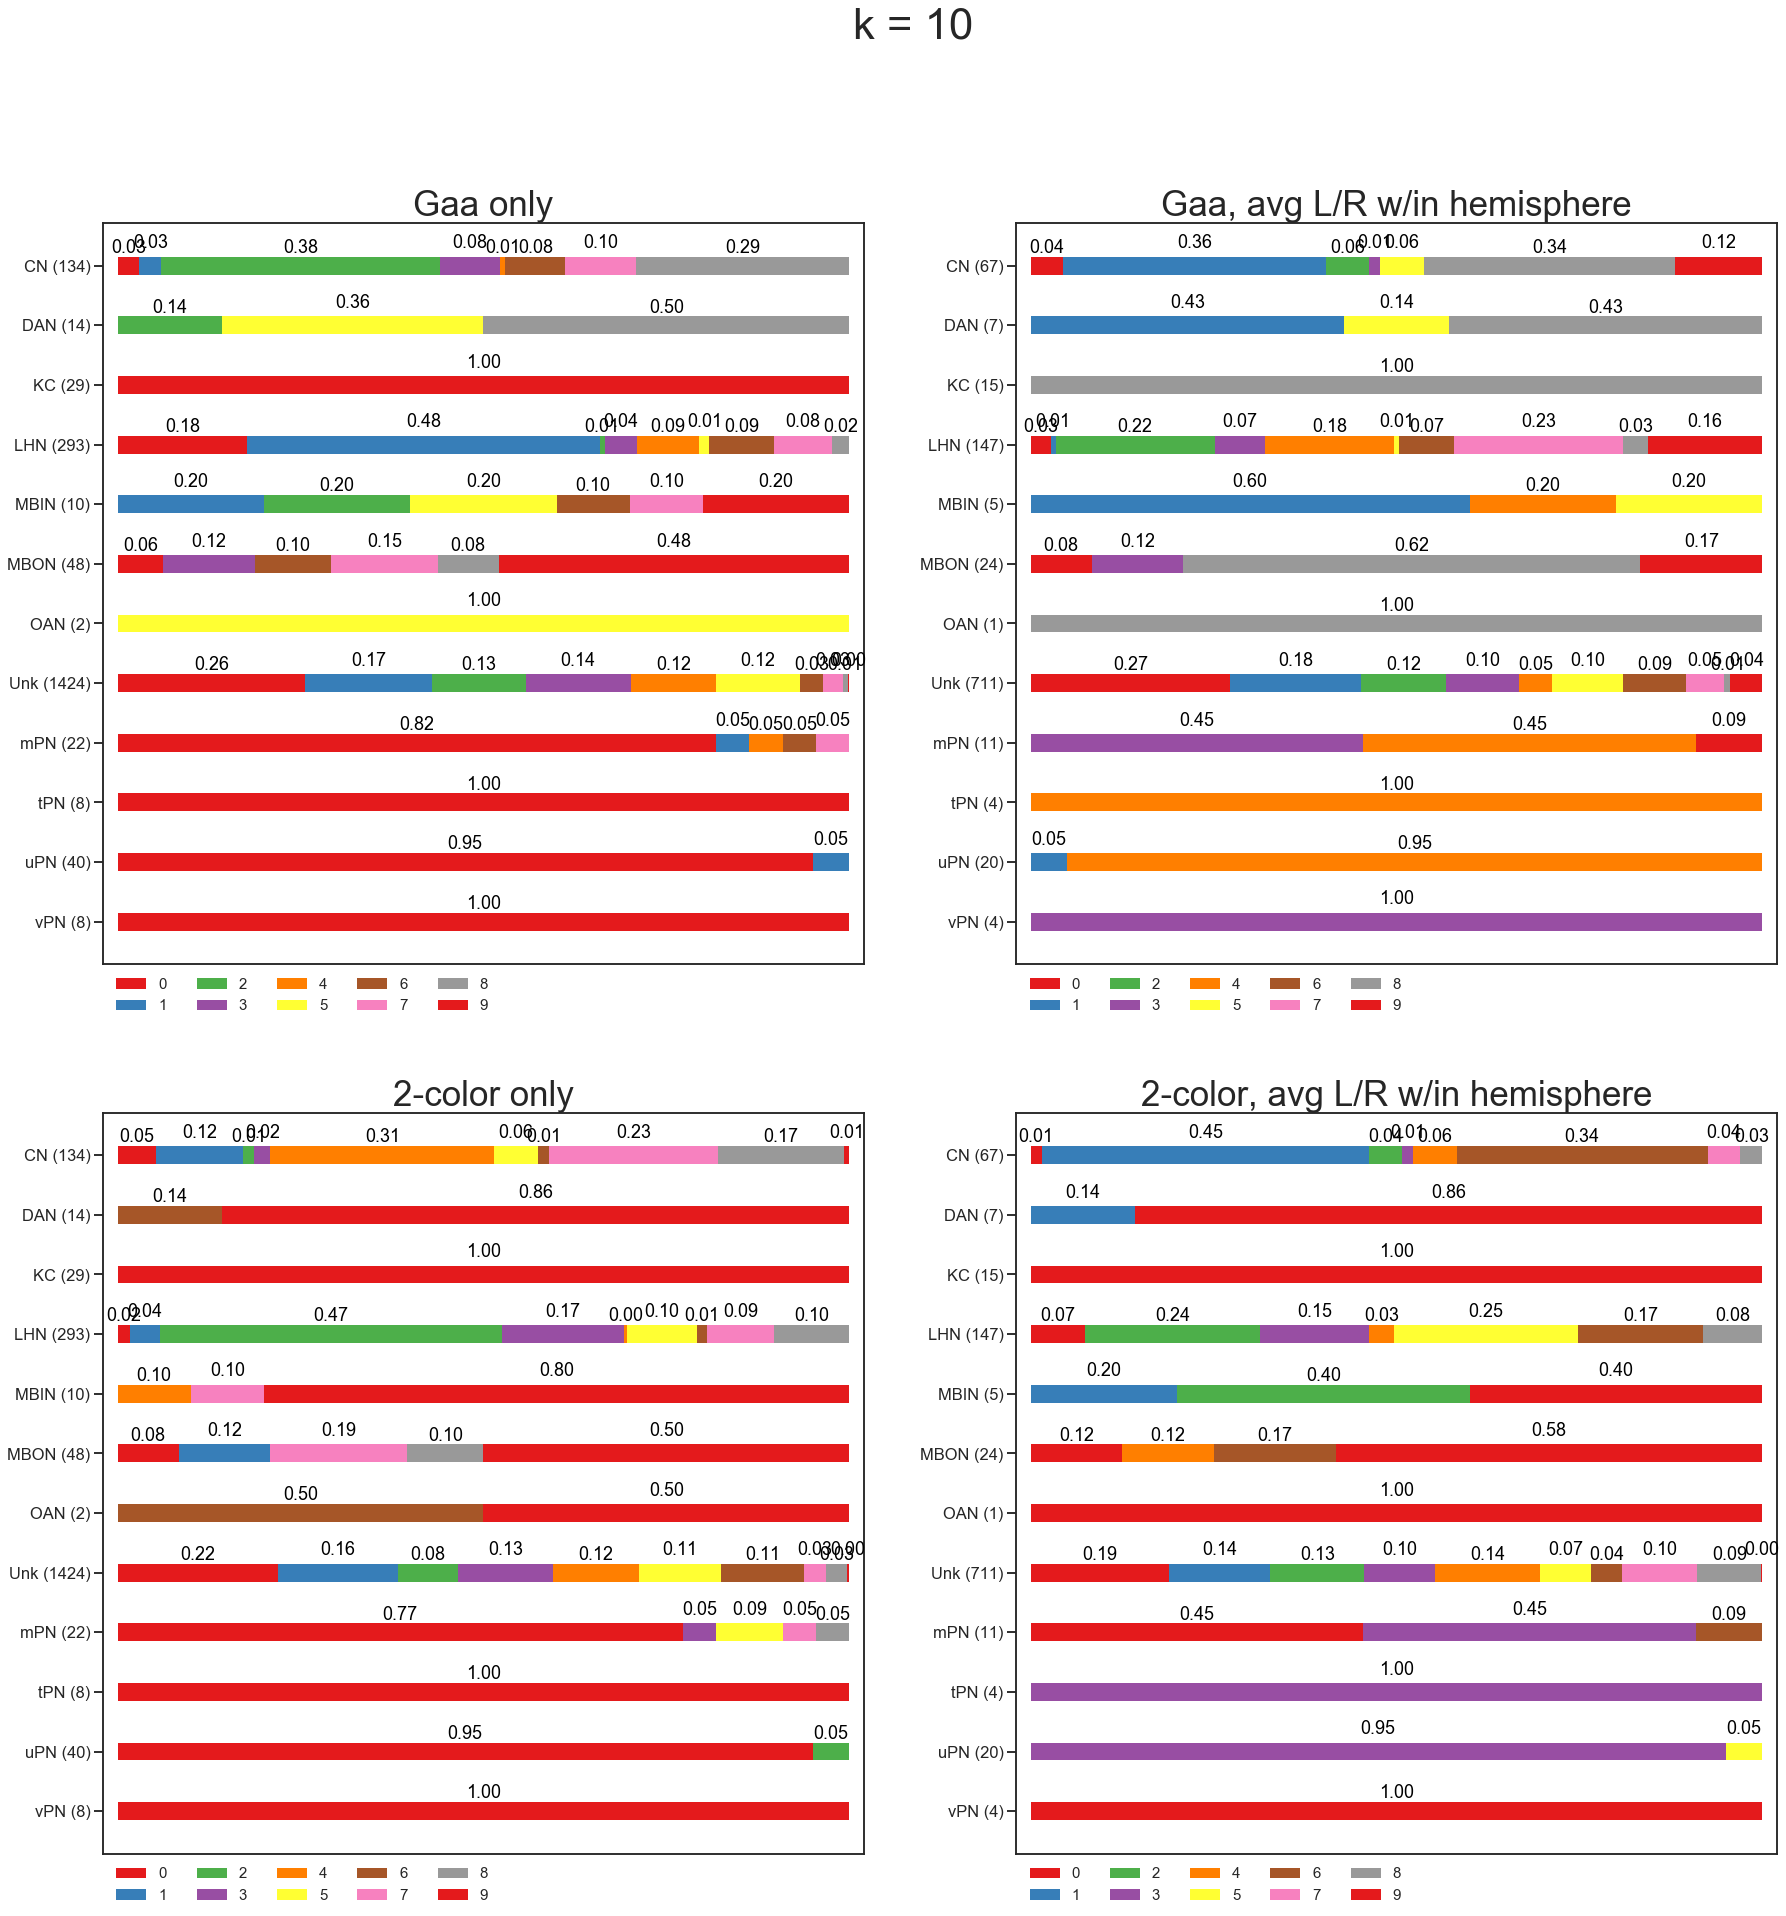

In [12]:


n_clusters = 10
skmeans_kws = dict(n_init=500, n_jobs=-2)

fontsize = 35


def estimate_clusters(latent, n_clusters, skmeans_kws):
    skmeans = SphericalKMeans(n_clusters=k, **skmeans_kws)
    pred_labels = skmeans.fit_predict(latent)
    pred_labels = relabel(pred_labels)
    return pred_labels


for k in range(2, n_clusters + 1):

    flat_pred_labels = estimate_clusters(flat_latent, k, skmeans_kws)
    avg_pred_labels = estimate_clusters(avg_latent, k, skmeans_kws)
    color_pred_labels = estimate_clusters(color_latent, k, skmeans_kws)
    avg_color_pred_labels = estimate_clusters(avg_color_latent, k, skmeans_kws)

    fig, ax = plt.subplots(2, 2, figsize=(30, 30))
    ax = ax.ravel()
    survey(class_labels, flat_pred_labels, ax=ax[0])
    ax[0].set_title("Gaa only", fontsize=fontsize)
    survey(class_labels[:n_per_side], avg_pred_labels, ax=ax[1])
    ax[1].set_title("Gaa, avg L/R w/in hemisphere", fontsize=fontsize)
    survey(class_labels, color_pred_labels, ax=ax[2])
    ax[2].set_title("2-color only", fontsize=fontsize)
    survey(class_labels[:n_per_side], avg_color_pred_labels, ax=ax[3])
    ax[3].set_title("2-color, avg L/R w/in hemisphere", fontsize=fontsize)
    plt.suptitle(f"k = {k}", fontsize = 1.25*fontsize)
